# Imports

In [1]:
%load_ext autoreload

In [53]:
%autoreload 2

import copy
import functools
import itertools
import logging
import re
import time
import yaml
from collections import Counter
import pathlib
from pathlib import Path
from pprint import pprint
import sys
from yaml import YAMLObject

import matplotlib
import humanize
from matplotlib import pyplot as plt, cm
import numpy as np
from numpy import ndarray
import pandas as pd
from pymicro.file import file_utils
import tensorflow as tf
from numpy.random import RandomState
from progressbar import progressbar as pbar
from enum import Enum
import re
from enum import Enum
from matplotlib import patches
from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import scipy as sp
from numpy import ndarray
from matplotlib import pyplot as plt, patches, cm
from sklearn import metrics as met
from progressbar import progressbar as pbar
from tensorflow.keras import layers
from sklearn import metrics, preprocessing
from sklearn import model_selection

from tomo2seg import modular_unet
from tomo2seg.logger import logger
from tomo2seg import data, viz
from tomo2seg.data import Volume
from tomo2seg.metadata import Metadata
from tomo2seg.volume_sequence import (
    VolumeCropSequence, MetaCrop3DGenerator, VSConstantEverywhere, 
    GTConstantEverywhere, SequentialGridPosition, ET3DConstantEverywhere
)
from tomo2seg import volume_sequence
from tomo2seg.model import Model as Tomo2SegModel
from tomo2seg.data import EstimationVolume
from tomo2seg import AggregationStrategy

# Setup

In [3]:
logger.setLevel(logging.DEBUG)

In [4]:
random_state = 42
random_state = np.random.RandomState(random_state)
runid = int(time.time())twe

SyntaxError: invalid syntax (<ipython-input-4-84007deb6c79>, line 3)

In [ ]:
logger.debug(f"{tf.__version__=}")
logger.info(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}\nThis should be 2 on R790-TOMO.")
logger.debug(f"Both here should return 2 devices...\n{tf.config.list_physical_devices('GPU')=}\n{tf.config.list_logical_devices('GPU')=}")

# xla auto-clustering optimization (see: https://www.tensorflow.org/xla#auto-clustering)
# this seems to break the training
tf.config.optimizer.set_jit(False)

# get a distribution strategy to use both gpus (see https://www.tensorflow.org/guide/distributed_training)
strategy = tf.distribute.MirroredStrategy()  
logger.debug(f"{strategy=}")

# Options

In [ ]:
analyze_crops = False

# tomo2seg objects

**tomo2seg.Model**

In [5]:
ls ../data/models | grep unet-2d-small

unet-2d-small.vanilla00.000.1605-971-456.autosaved.hdf5
unet-2d-small.vanilla00.000.1605-972-712/
unet-2d-small.vanilla00.000.1605-972-712.autosaved.hdf5
unet-2d-small.vanilla00.000.1605-982-196/
unet-2d-small.vanilla00.000.1605-982-196.autosaved.hdf5


In [6]:
tomo2seg_model = Tomo2SegModel.build_from_model_name(
    "unet-2d-small.vanilla00.000.1605-982-196"
)
logger.info(f"{tomo2seg_model=}")

INFO::tomo2seg::{<ipython-input-6-cfe47d5c3241>:<module>:004}::[2020-12-01::22:39:00.620]
tomo2seg_model=Model(master_name='unet-2d-small', version='vanilla00', fold=0, runid=1605982196, factory_function=None, factory_kwargs=None)



**tomo2seg.Volume**

In [7]:
from tomo2seg.datasets import (
#     VOLUME_COMPOSITE_V1 as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_REDUCED as VOLUME_NAME_VERSION,
    VOLUME_COMPOSITE_V1_LABELS_REFINED3 as LABELS_VERSION
)

volume_name, volume_version = VOLUME_NAME_VERSION
labels_version = LABELS_VERSION

logger.info(f"{volume_name=} {volume_version=} {labels_version=}")

volume = Volume.with_check(
    name=volume_name, version=volume_version
)
logger.info(f"{volume=}")

def _read_raw(path_: Path, volume_: Volume, dims=None): 
    # from pymicro
    return file_utils.HST_read(
        str(path_),  # it doesn't accept paths...
        # pre-loaded kwargs
        autoparse_filename=False,  # the file names are not properly formatted
        data_type=volume.metadata.dtype,
        dims=dims or volume.metadata.dimensions,
        verbose=True,
    )

read_raw = functools.partial(_read_raw, volume_=volume)

INFO::tomo2seg::{<ipython-input-7-bf00897f594c>:<module>:010}::[2020-12-01::22:39:07.029]
volume_name='PA66GF30' volume_version='v1-reduced' labels_version='refined3'

DEBUG::tomo2seg::{data.py:with_check:237}::[2020-12-01::22:39:07.030]
vol=Volume(name='PA66GF30', version='v1-reduced', _metadata=None)

ERROR::tomo2seg::{data.py:with_check:255}::[2020-12-01::22:39:07.038]
Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.labels.raw

Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.weights.raw

DEBUG::tomo2seg::{data.py:metadata:194}::[2020-12-01::22:39:07.041]
Loading metadata from `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1-reduced/PA66GF30.v1-reduced.metadata.yml`.

INFO::tomo2seg::{<ipython-input-7-bf00897f594c>:<module>:015}::[2020-12-01::22:39:07.055]
volume=Volume(name='PA66GF30', version='v1-reduced', _metadata=Volume.Metadata(dimensions=[256, 256, 256], dtype='uint8', l

**partition**

In [17]:
# data_volume = voldata_train
# partition = volume.val_partition
partition = volume.test_partition
runid = 1606072056

volume_and_partition_name = f"{volume.fullname}.partition={partition.alias}"

logger.debug(f"{partition=}")
logger.debug(f"{partition.shape=}")
logger.debug(f"{runid=}")
logger.debug(f"{volume_and_partition_name=}")

read_raw_partition = functools.partial(_read_raw, volume_=volume, dims=partition.shape)

DEBUG::tomo2seg::{<ipython-input-17-90b1106209fd>:<module>:008}::[2020-12-01::22:43:50.868]
partition=SetPartition(x_range=(0, 256), y_range=(0, 256), z_range=(192, 256), alias='test')

DEBUG::tomo2seg::{<ipython-input-17-90b1106209fd>:<module>:009}::[2020-12-01::22:43:50.869]
partition.shape=(256, 256, 64)

DEBUG::tomo2seg::{<ipython-input-17-90b1106209fd>:<module>:010}::[2020-12-01::22:43:50.870]
runid=1606072056

DEBUG::tomo2seg::{<ipython-input-17-90b1106209fd>:<module>:011}::[2020-12-01::22:43:50.871]
volume_and_partition_name='PA66GF30.v1-reduced.partition=test'



**tomo2seg.EstimationVolume**

In [25]:
estimation_volume = EstimationVolume.from_objects(
    volume=volume, 
    model=tomo2seg_model, 
    set_partition=partition,
    runid=runid,
)
logger.info(f"{estimation_volume=}")

figs_dir = estimation_volume.dir

INFO::tomo2seg::{<ipython-input-25-bafe1e91b086>:<module>:007}::[2020-12-01::23:09:34.079]
estimation_volume=EstimationVolume(volume_fullname='PA66GF30.v1-reduced', model_name='unet-2d-small.vanilla00.fold000.1605-982-196', runid=1606072056, partition=SetPartition(x_range=(0, 256), y_range=(0, 256), z_range=(192, 256), alias='test'))



# Load data

**data**

In [26]:
logger.debug("Loading data from disk.")

data_volume = read_raw(volume.data_path)
logger.debug(f"{data_volume.shape=}")

data_volume = partition.get_volume_partition(data_volume)
logger.debug(f"(only {partition.alias=}) {data_volume.shape=}")

DEBUG::tomo2seg::{<ipython-input-26-f6d550b2d9c3>:<module>:001}::[2020-12-01::23:09:35.551]
Loading data from disk.

data type is uint8
volume size is 256 x 256 x 256
reading volume... from byte 0
DEBUG::tomo2seg::{<ipython-input-26-f6d550b2d9c3>:<module>:004}::[2020-12-01::23:09:35.632]
data_volume.shape=(256, 256, 256)

DEBUG::tomo2seg::{<ipython-input-26-f6d550b2d9c3>:<module>:007}::[2020-12-01::23:09:35.635]
(only partition.alias='test') data_volume.shape=(256, 256, 64)



**Labels**

In [27]:
labels_volume = read_raw(volume.versioned_labels_path(labels_version))
logger.debug(f"{labels_volume.shape=}")

labels_volume = partition.get_volume_partition(labels_volume)
logger.debug(f"(only {partition.alias=}) {labels_volume.shape=}")

data type is uint8
volume size is 256 x 256 x 256
reading volume... from byte 0
DEBUG::tomo2seg::{<ipython-input-27-5b1b50957cf2>:<module>:002}::[2020-12-01::23:09:36.734]
labels_volume.shape=(256, 256, 256)

DEBUG::tomo2seg::{<ipython-input-27-5b1b50957cf2>:<module>:005}::[2020-12-01::23:09:36.735]
(only partition.alias='test') labels_volume.shape=(256, 256, 64)



**Probabilities**

In [31]:
probabilities_are_available = False

if estimation_volume.probabilities_path.exists():
    # float16 instead of 64 to save memory
    probas_volume = np.load(estimation_volume.probabilities_path).astype(np.float16)
    logger.debug(f"{probas_volume.shape=}")
    probabilities_are_available = True
    
else:
    logger.info("Probabilities are not available.")

DEBUG::tomo2seg::{<ipython-input-31-5abccb8499c7>:<module>:006}::[2020-12-01::23:11:20.212]
probas_volume.shape=(256, 256, 64, 3)



**Predictions**

In [30]:
predictions_volume = read_raw_partition(estimation_volume.predictions_path)
logger.debug(f"{predictions_volume.shape=}")

data type is uint8
volume size is 256 x 256 x 64
reading volume... from byte 0
DEBUG::tomo2seg::{<ipython-input-30-fb06bad75c33>:<module>:002}::[2020-12-01::23:11:15.970]
predictions_volume.shape=(256, 256, 64)



# Class imbalance

In [32]:
labels_idx = volume.metadata.labels
labels_names = [volume.metadata.labels_names[idx] for idx in labels_idx]
n_classes = len(labels_idx)

logger.debug(f"{labels_idx=}\n{labels_names=}\n{n_classes=}")

DEBUG::tomo2seg::{<ipython-input-32-470efc35a83d>:<module>:005}::[2020-12-01::23:11:24.569]
labels_idx=[0, 1, 2]
labels_names=['matrix', 'fiber', 'porosity']
n_classes=3



In [33]:
logger.info("Computing label class imbalance.")
_, labels_counts = np.unique(labels_volume, return_counts=True)

INFO::tomo2seg::{<ipython-input-33-7e3186c17741>:<module>:001}::[2020-12-01::23:11:27.383]
Computing label class imbalance.



INFO::tomo2seg::{viz.py:plot:636}::[2020-12-01::23:11:29.409]
The minimum accuracy is: random_model_accu=79.77%

INFO::tomo2seg::{<ipython-input-34-085ae63c31fe>:<module>:010}::[2020-12-01::23:11:29.410]
Saving figure (figname := display.title + '.png')='PA66GF30.v1-reduced.partition=test.class-imbalance.png'



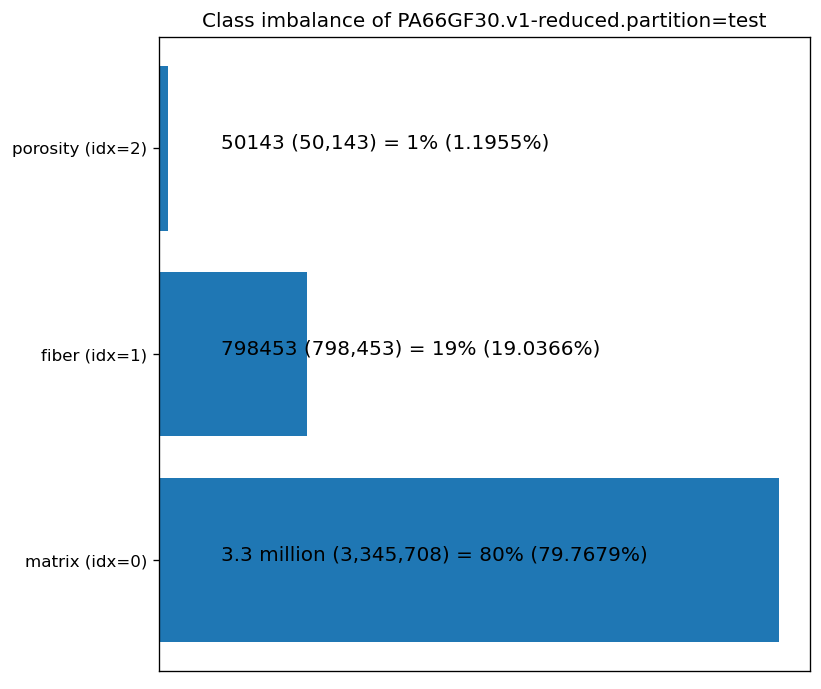

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(sz := 7, sz), dpi=(dpi := 120))

display = viz.ClassImbalanceDisplay(
    volume_name=volume_and_partition_name,
    labels_idx=labels_idx,
    labels_names=labels_names,
    labels_counts=labels_counts,
).plot(ax)

logger.info(f"Saving figure {(figname := display.title + '.png')=}")
display.fig_.savefig(
    fname=figs_dir / figname,
    format="png",
    metadata=display.metadata,
)    

# Value histograms

In [35]:
data_volume_raveled_t = tf.convert_to_tensor(
    value=data_volume.ravel(),
    dtype=tf.int32,
)

## All data

In [36]:
data_hist_t = tf.histogram_fixed_width(
    values=data_volume_raveled_t,
    value_range=tf.constant((hist_range := [0, 255]), dtype=data_volume_raveled_t.dtype),
    nbins=(n_bins := 256),
    dtype=data_volume_raveled_t.dtype,
    name=f"{volume.fullname}.data-histogram"
)
data_hist_t = data_hist_t / tf.math.reduce_sum(data_hist_t)
# todo save these values# 

INFO::tomo2seg::{<ipython-input-37-b1f18ac9ca0e>:<module>:010}::[2020-12-01::23:11:42.134]
Saving figure (figname := display.title + '.png')='PA66GF30.v1-reduced.partition=test.voxel-value-histogram.png'



/home/joaopcbertoldo/projects/tomo2seg/tomo2seg/viz.py:693: UserWarning: FixedFormatter should only be used together with FixedLocator
  axlog.set_yticklabels(


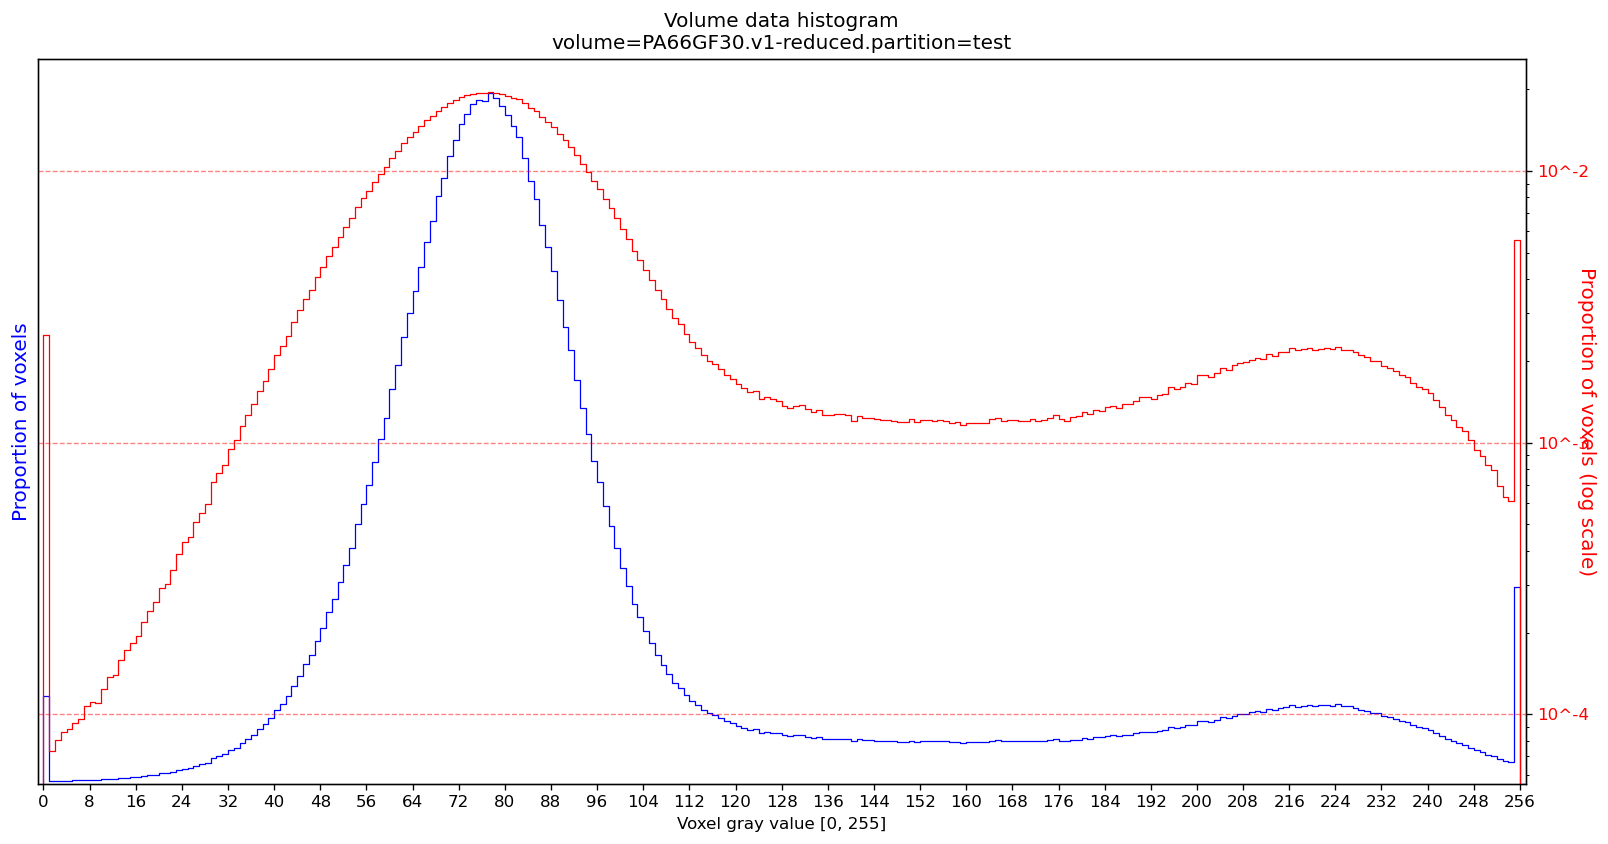

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(2* (sz := 8), sz), dpi=(dpi := 120))

# i want to get the vertical borders to show up
display = viz.VoxelValueHistogramDisplay(
    volume_name=volume_and_partition_name,
    bins=np.linspace(*hist_range, n_bins).astype(int).tolist(),
    values=data_hist_t.numpy().tolist(),
).plot(ax)
 
logger.info(f"Saving figure {(figname := display.title + '.png')=}")
display.fig_.savefig(
    fname=figs_dir / figname,
    format="png",
    metadata=display.metadata,
)    

## Per label

In [38]:
labels_volume_raveled_t = tf.convert_to_tensor(
    labels_volume.ravel(), dtype=tf.int8
)

In [39]:
data_hists_per_label = []
data_hists_per_label_global_prop = []
n_voxels = np.sum(labels_counts)

for label_idx in labels_idx:
    logger.debug(f"Computing histogram for {label_idx=}")
    
    label_data_hist_t = tf.histogram_fixed_width(
        values=data_volume_raveled_t[labels_volume_raveled_t == label_idx],
        value_range=tf.constant(hist_range, dtype=data_volume_raveled_t.dtype),
        nbins=n_bins,
        dtype=data_volume_raveled_t.dtype,
        name=f"{volume.fullname}.data-histogram"
    )
    data_hists_per_label.append(
        (label_data_hist_t / tf.math.reduce_sum(label_data_hist_t)).numpy().tolist()
    )
    data_hists_per_label_global_prop.append(
        (label_data_hist_t.numpy() / n_voxels).tolist()
    )

DEBUG::tomo2seg::{<ipython-input-39-d94bc39a492e>:<module>:006}::[2020-12-01::23:11:43.201]
Computing histogram for label_idx=0

DEBUG::tomo2seg::{<ipython-input-39-d94bc39a492e>:<module>:006}::[2020-12-01::23:11:43.333]
Computing histogram for label_idx=1

DEBUG::tomo2seg::{<ipython-input-39-d94bc39a492e>:<module>:006}::[2020-12-01::23:11:43.353]
Computing histogram for label_idx=2



INFO::tomo2seg::{<ipython-input-40-a125f566f367>:<module>:018}::[2020-12-01::23:11:47.291]
Saving figure (figname := display.title + '.png')='PA66GF30.v1-reduced.partition=test.data-histogram-per-label.png'



/home/joaopcbertoldo/projects/tomo2seg/tomo2seg/viz.py:786: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax_global.set_ybound(lower=0)


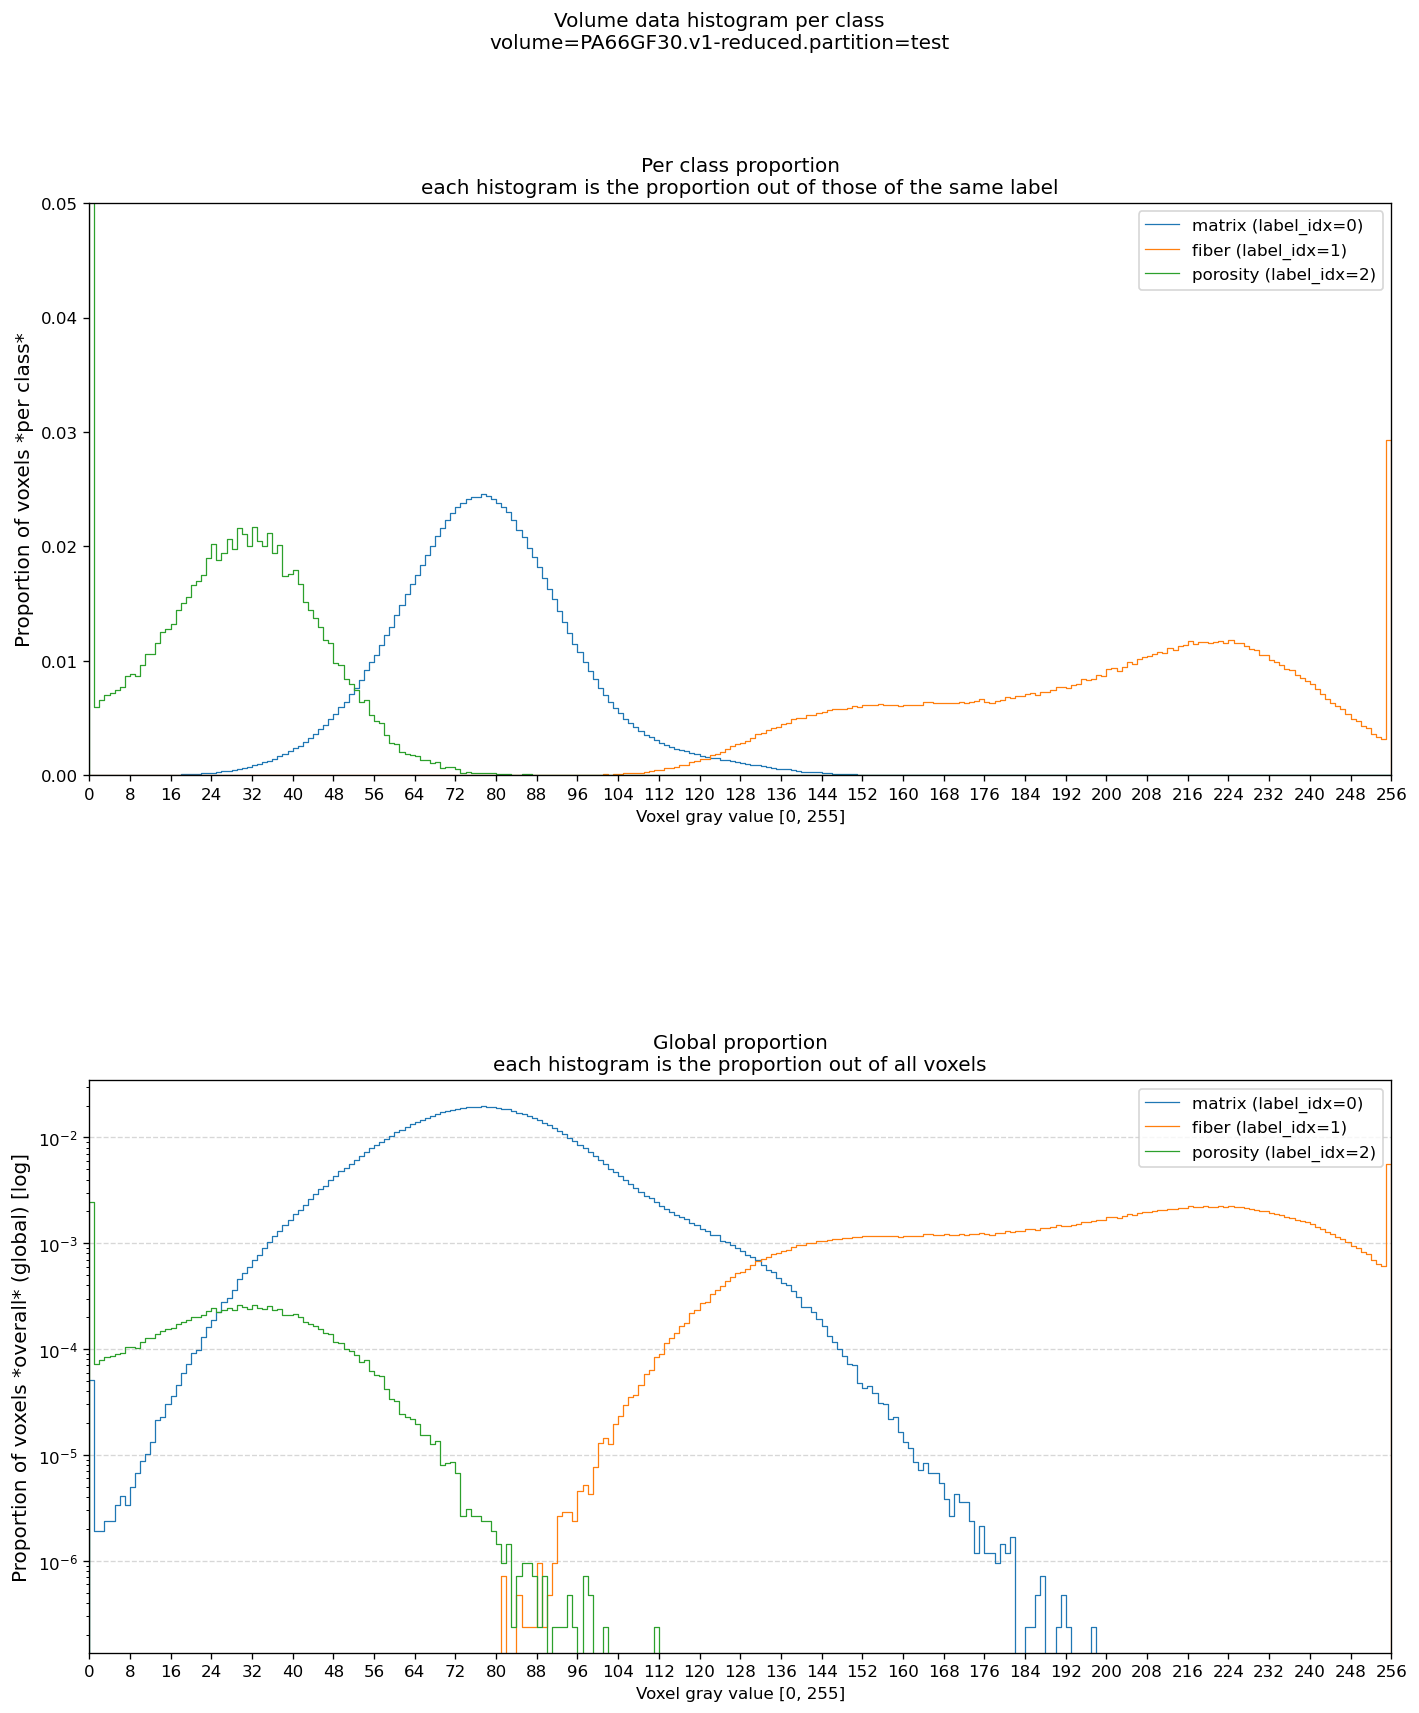

In [40]:
fig, axs = plt.subplots(
    nrows := 2, ncols := 1, figsize=(ncols * 1.75 * (sz := 8), nrows * sz), dpi=(dpi := 120),
    gridspec_kw=dict(hspace=sz/15)
)

bins = np.linspace(*hist_range, n_bins).astype(int).tolist()

display = viz.VoxelValueHistogramPerClassDisplay(
    volume_name=volume_and_partition_name,
    bins=bins,
    values_per_label=data_hists_per_label,
    values_per_label_global_proportion=data_hists_per_label_global_prop,
    labels_idx=labels_idx,
    labels_names=labels_names,
).plot(axs)
axs[0].set_ylim(top=.05)
 
logger.info(f"Saving figure {(figname := display.title + '.png')=}")
display.fig_.savefig(
    fname=figs_dir / figname,
    format="png",
    metadata=display.metadata,
)    

# Per-class predicted probabilities histograms

In [41]:
logger.info("Computing probability histograms per label.")
probas_volume_reshaped = probas_volume.reshape(-1, n_classes)

INFO::tomo2seg::{<ipython-input-41-d04daec5ceae>:<module>:001}::[2020-12-01::23:11:49.429]
Computing probability histograms per label.



In [42]:
histograms = []
bins = np.linspace(0, 1, 101)

for label_idx in labels_idx:
    logger.debug(f"Computing histogram for {label_idx=}")
    
    selector = labels_volume.ravel() == label_idx
    
    label_hists = []
    for class_proba_idx in labels_idx:
        values, _ = np.histogram(
            probas_volume_reshaped[selector, class_proba_idx], bins=bins
        ) 
        label_hists.append(values / values.sum())
        
    histograms.append(label_hists)
    
histograms = np.array(histograms)

DEBUG::tomo2seg::{<ipython-input-42-4993648b602d>:<module>:005}::[2020-12-01::23:11:49.472]
Computing histogram for label_idx=0

DEBUG::tomo2seg::{<ipython-input-42-4993648b602d>:<module>:005}::[2020-12-01::23:11:50.104]
Computing histogram for label_idx=1

DEBUG::tomo2seg::{<ipython-input-42-4993648b602d>:<module>:005}::[2020-12-01::23:11:50.331]
Computing histogram for label_idx=2



In [43]:
logger.info(f"Saving probabilities histograms at `{estimation_volume.probabilities_histograms_path=}`")
np.save(
    estimation_volume.probabilities_histograms_path,
    histograms
)

INFO::tomo2seg::{<ipython-input-43-99c8ff0f8ff0>:<module>:001}::[2020-12-01::23:11:50.455]
Saving probabilities histograms at `estimation_volume.probabilities_histograms_path=PosixPath('/home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056.probabilities-histograms.npy')`



DEBUG::tomo2seg::{<ipython-input-44-b87d9f8fd372>:<module>:011}::[2020-12-01::23:11:50.582]
Plotting histograms for label_idx=0

DEBUG::tomo2seg::{<ipython-input-44-b87d9f8fd372>:<module>:011}::[2020-12-01::23:11:50.620]
Plotting histograms for label_idx=1

DEBUG::tomo2seg::{<ipython-input-44-b87d9f8fd372>:<module>:011}::[2020-12-01::23:11:50.657]
Plotting histograms for label_idx=2

INFO::tomo2seg::{<ipython-input-44-b87d9f8fd372>:<module>:030}::[2020-12-01::23:11:50.695]
Saving figure (figname := display.title + '.png')='probabilities-histogram.png'



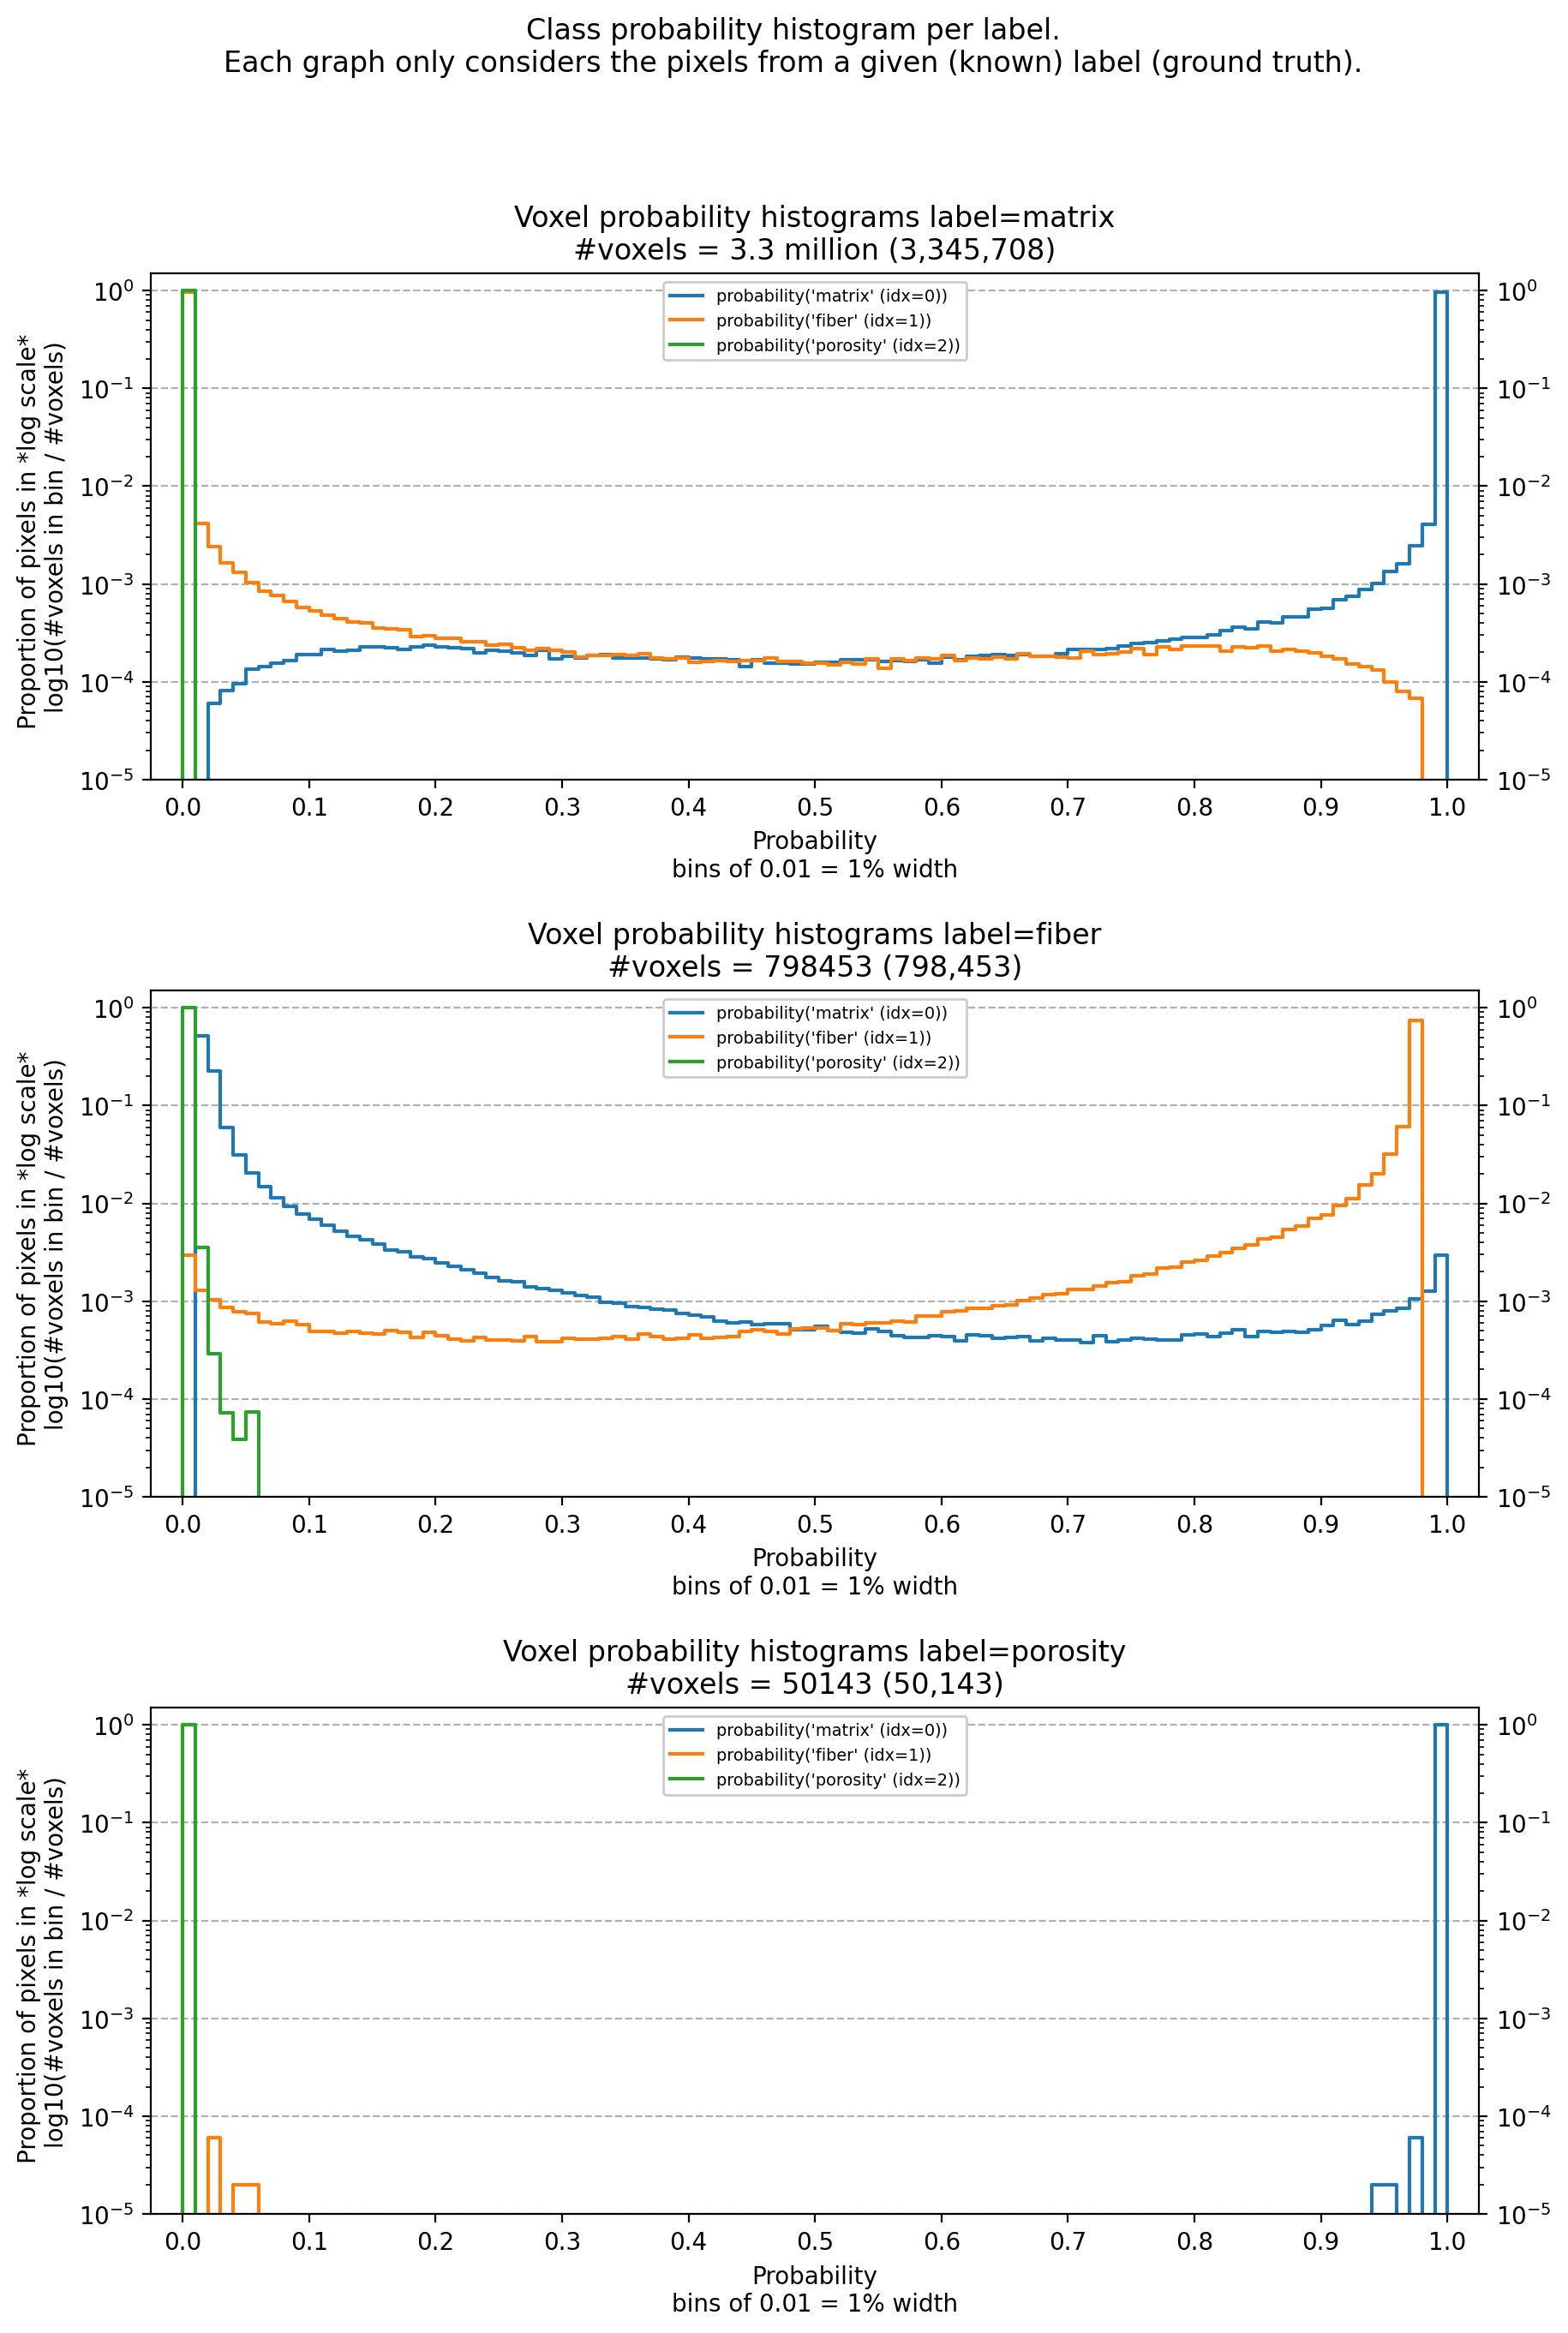

In [44]:
fig, axs = plt.subplots(
    nrows := 3, 
    ncols := 1, 
    figsize=(2 * ncols * (sz := 5), nrows * sz), 
    dpi=200,
    gridspec_kw=dict(wspace=0, hspace=sz/12)
)

for label_idx, label_name, label_n_voxels, ax in zip(labels_idx, labels_names, labels_counts, axs.ravel()):
    
    logger.debug(f"Plotting histograms for {label_idx=}")
    
    display = viz.ClassProbabilityHistogramDisplay(
        bins=bins.tolist(),
        values_per_class=histograms[label_idx].tolist(),
        labels_idx=labels_idx,
        labels_names=labels_names,
    ).plot(ax)
    
    title_complement = f" label={label_name}"
    title_complement += f"\n#voxels = {humanize.intword(label_n_voxels)} ({humanize.intcomma(label_n_voxels)})"
    
    ax.set_title(ax.get_title() + title_complement)

fig.suptitle(
    "Class probability histogram per label."
    "\nEach graph only considers the pixels from a given (known) label (ground truth)."
)
    
logger.info(f"Saving figure {(figname := display.title + '.png')=}")
display.fig_.savefig(
    fname=figs_dir / figname,
    format="png",
    metadata=display.metadata,
)    

# Prediction normalized entropy

In [45]:
logger.info("Computing voxels' probability distribution normalized entropy.")

probas_volume_t = tf.convert_to_tensor(
    value=probas_volume,
    dtype=tf.float32,
)

eps = 1e-6
max_entropy = - np.log(1 / (n_classes + eps))

# tensors are faster
# normalized_voxel_entropies = - (probas_volume * np.log(probas_volume + eps)).sum(axis=-1) / max_entropy

# entropy
normalized_voxel_entropies_t = - tf.math.reduce_sum(
    tf.math.multiply(probas_volume_t, tf.math.log(probas_volume_t + eps)), 
    axis=-1
)

# normalize it
normalized_voxel_entropies_t = tf.math.divide(normalized_voxel_entropies_t, max_entropy)

normalized_voxel_entropies = normalized_voxel_entropies_t.numpy()

del probas_volume_t

logger.debug(f"{normalized_voxel_entropies.shape=}")

path = str(estimation_volume.voxel_normalized_entropy_path)
logger.info(f"Saving normalized entropies volume to {path=}")

file_utils.HST_write(
    # it has to be 32 to read it in fiji 
    normalized_voxel_entropies.astype(np.float32), 
    path
)

INFO::tomo2seg::{<ipython-input-45-2afbbfcf4baf>:<module>:001}::[2020-12-01::23:11:53.569]
Computing voxels' probability distribution normalized entropy.

DEBUG::tomo2seg::{<ipython-input-45-2afbbfcf4baf>:<module>:027}::[2020-12-01::23:11:53.904]
normalized_voxel_entropies.shape=(256, 256, 64)

INFO::tomo2seg::{<ipython-input-45-2afbbfcf4baf>:<module>:030}::[2020-12-01::23:11:53.905]
Saving normalized entropies volume to path='/home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056.voxel-normalized-entropy.raw'

opening /home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056.voxel-normalized-entropy.raw f

In [46]:
logger.debug("Computing normalized entropy histograms per label.")

entropy_histograms = []

normalized_voxel_entropies_t = tf.reshape(normalized_voxel_entropies_t, (-1,))

range_ = tf.constant([0., 1.], dtype=normalized_voxel_entropies_t.dtype)
nbins = 100

range_np = range_.numpy()
bins_borders = np.linspace(range_np[0], range_np[1], nbins + 1, endpoint=True)

for label_idx in labels_idx:
    logger.debug(f"Computing histogram for {label_idx=}")
    
    selector = (labels_volume == label_idx).ravel()
    
    entropy_hist_t = tf.histogram_fixed_width(
        values=normalized_voxel_entropies_t[selector],
        value_range=range_,
        nbins=nbins,
        dtype=tf.int32,
    )
    entropy_hist_t = tf.math.divide(entropy_hist_t, tf.math.reduce_sum(entropy_hist_t))
    entropy_histograms.append(entropy_hist_t.numpy())
    
entropy_histograms = np.array(entropy_histograms)

del normalized_voxel_entropies_t

DEBUG::tomo2seg::{<ipython-input-46-1a82b2d8371a>:<module>:001}::[2020-12-01::23:11:54.042]
Computing normalized entropy histograms per label.

DEBUG::tomo2seg::{<ipython-input-46-1a82b2d8371a>:<module>:014}::[2020-12-01::23:11:54.044]
Computing histogram for label_idx=0

DEBUG::tomo2seg::{<ipython-input-46-1a82b2d8371a>:<module>:014}::[2020-12-01::23:11:54.122]
Computing histogram for label_idx=1

DEBUG::tomo2seg::{<ipython-input-46-1a82b2d8371a>:<module>:014}::[2020-12-01::23:11:54.162]
Computing histogram for label_idx=2



In [47]:
logger.info(f"Saving normalized entropy histograms at `{estimation_volume.voxel_normalized_entropy_histograms_path=}`")
np.save(
    estimation_volume.voxel_normalized_entropy_histograms_path,
    entropy_histograms
)

INFO::tomo2seg::{<ipython-input-47-5086f4933fb0>:<module>:001}::[2020-12-01::23:12:25.026]
Saving normalized entropy histograms at `estimation_volume.voxel_normalized_entropy_histograms_path=PosixPath('/home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056.voxel-normalized-entropy-histograms.npy')`



DEBUG::tomo2seg::{<ipython-input-51-d8d501e2393f>:<module>:001}::[2020-12-01::23:16:55.008]
Saving figure (fig_name := 'normalized-entropy-histogram-per-label.png')='normalized-entropy-histogram-per-label.png'

DEBUG::tomo2seg::{<ipython-input-51-d8d501e2393f>:<module>:011}::[2020-12-01::23:16:55.031]
Plotting histogram for label_idx=0

DEBUG::tomo2seg::{<ipython-input-51-d8d501e2393f>:<module>:011}::[2020-12-01::23:16:55.057]
Plotting histogram for label_idx=1

DEBUG::tomo2seg::{<ipython-input-51-d8d501e2393f>:<module>:011}::[2020-12-01::23:16:55.066]
Plotting histogram for label_idx=2



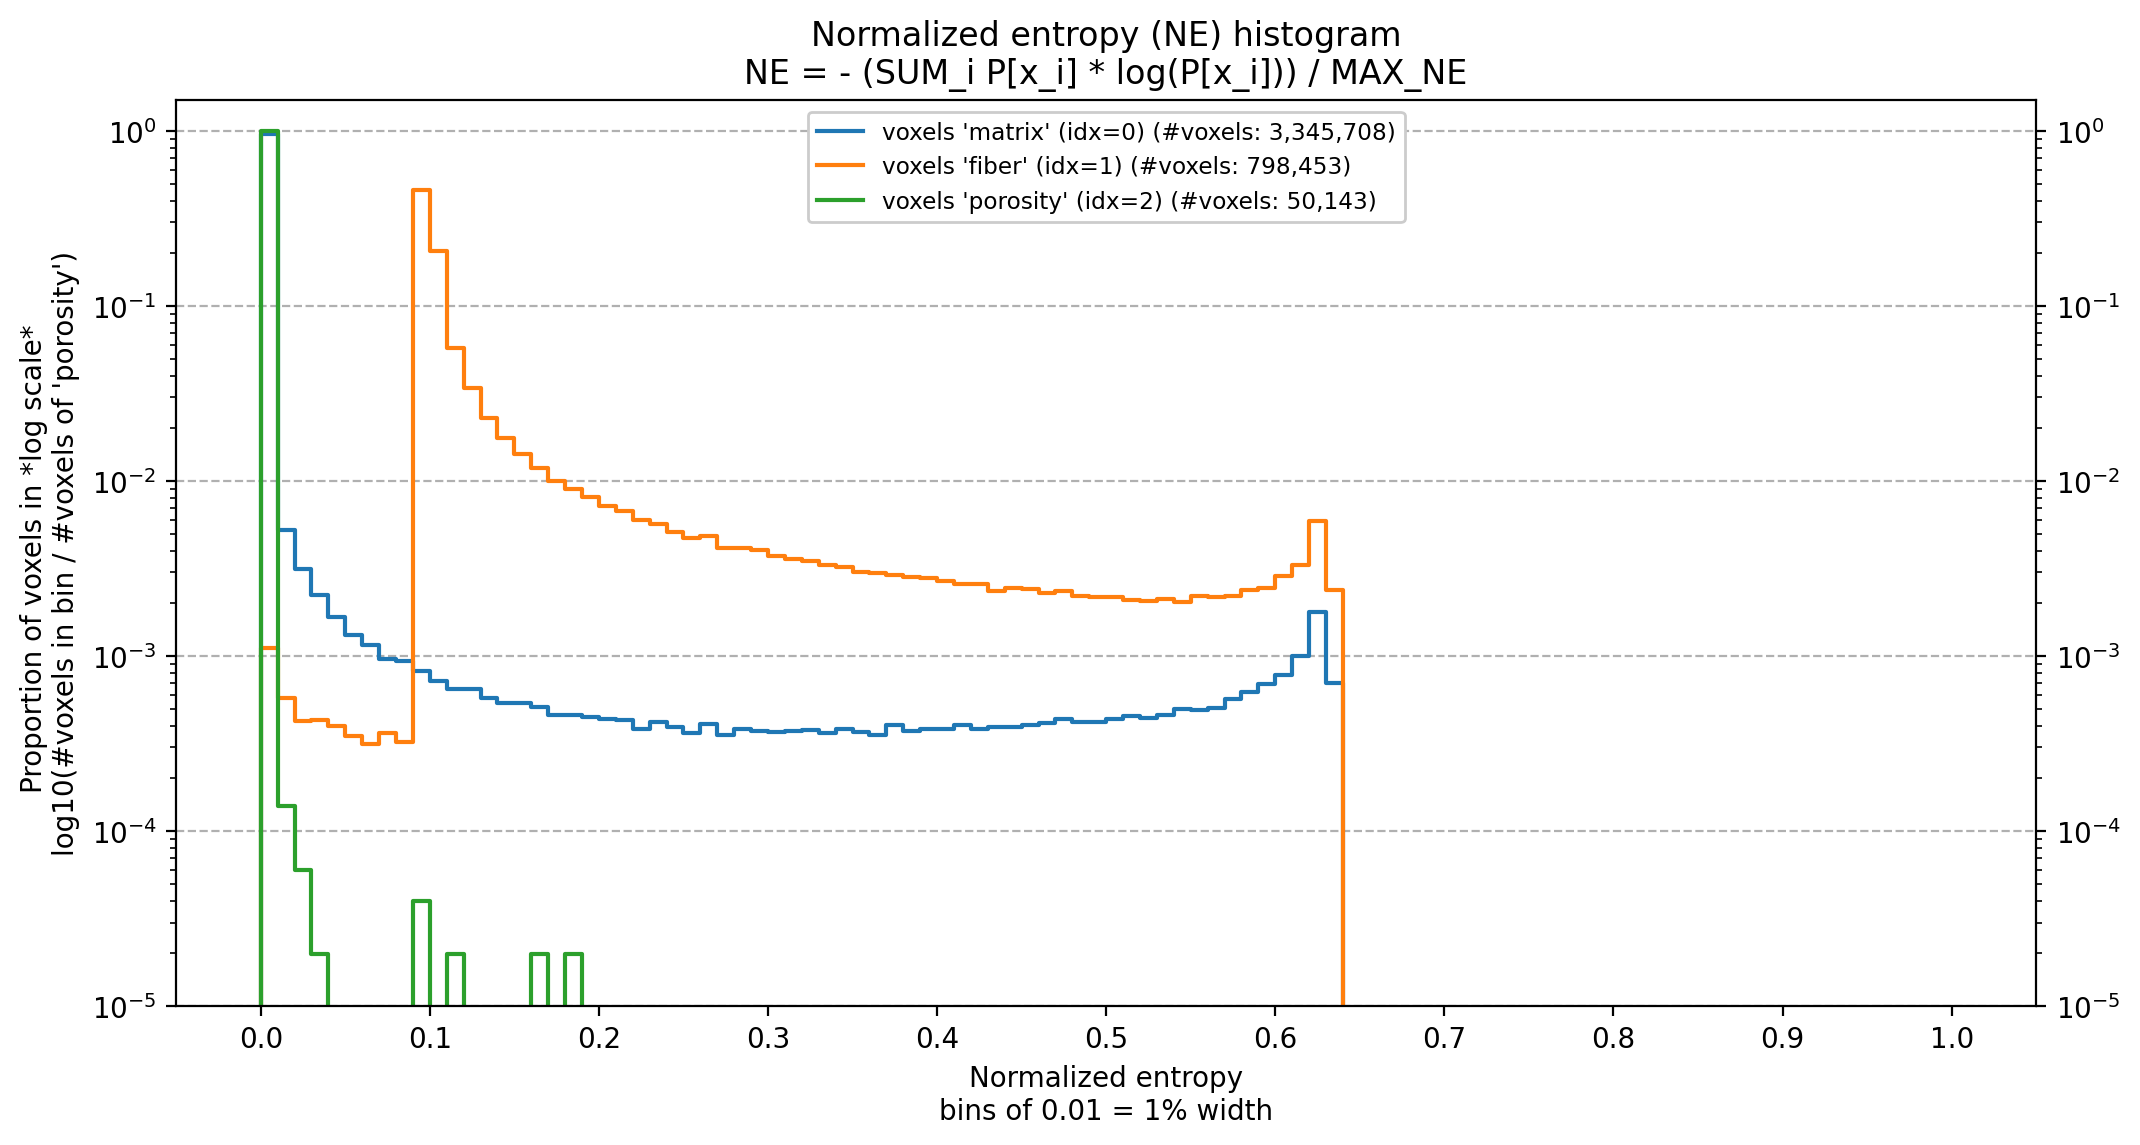

In [51]:
logger.debug(f"Saving figure {(fig_name := 'normalized-entropy-histogram-per-label.png')=}")

fig, ax = plt.subplots(
    1, 1, figsize=(2 * (sz := 6), sz), dpi=(dpi := 200),
)
xlims = (-.05, 1.05)
ylims_10pow = (-5, 0)
ylims = tuple(10 ** p for p in ylims_10pow)

for label_idx in labels_idx:
    logger.debug(f"Plotting histogram for {label_idx=}")
    
    ax.step(
        np.concatenate([bins, [1.001]]),
        np.concatenate([[0], entropy_histograms[label_idx], [0]]),
        label=f"voxels '{labels_names[label_idx]}' (idx={label_idx}) (#voxels: {humanize.intcomma(labels_counts[label_idx])})",
        linewidth=1.5
    )
    
    ax.set_yscale('log')
    ax.set_ylim(ylims[0], 1.5 * ylims[1])
    ax.set_yticks(np.logspace(ylims_10pow[0], ylims_10pow[1], ylims_10pow[1] - ylims_10pow[0] + 1))
    ax.set_ylabel(
        f"Proportion of voxels in *log scale* \n"
        f"log10(#voxels in bin / #voxels of '{(label_name := labels_names[label_idx])}')"
    )
    
    ax.set_xlim(*xlims)
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.set_xlabel("Normalized entropy\nbins of 0.01 = 1% width")

    ax.tick_params(axis='y', left=True, right=True, labelleft=True, labelright=True, which="both")    
    ax.grid(True, axis='y', which='major', ls='--')    
    
    ax.set_title(
        f"Normalized entropy (NE) histogram\n"
        f"NE = - (SUM_i P[x_i] * log(P[x_i])) / MAX_NE" 
    )
    ax.legend(loc="upper center", fontsize="small", framealpha=1)

# logger.info(f"Saving figure {(figname := display.title + '.png')=}")
# display.fig_.savefig(
#     fname=figs_dir / figname,
#     format="png",
#     metadata=display.metadata,
# )

# Probabilities plane (2D)

It is possible to visualize the probabilities on a plane because 

$$\sum_{i = 1}^{n\_classes} p_i = 1$$

So, when $n\_classes = 3$, we actually have 2 degrees of freedom. 

In [56]:
random_state = np.random.RandomState(32)

In [58]:
probas_volume_reshaped = probas_volume.reshape(-1, 3)

INFO::tomo2seg::{<timed exec>:<module>:001}::[2020-12-01::23:19:23.187]
Saving figure of probabilities scattered on a plane (fig_name := f'probabilities-scatter.png')='probabilities-scatter.png'

DEBUG::tomo2seg::{<timed exec>:<module>:014}::[2020-12-01::23:19:23.208]
(x_label, y_label, z_label)=(0, 1, 2)

DEBUG::tomo2seg::{<timed exec>:<module>:027}::[2020-12-01::23:19:23.211]
n_per_label=10000

DEBUG::tomo2seg::{<timed exec>:<module>:051}::[2020-12-01::23:19:23.243]
label_idx=0

DEBUG::tomo2seg::{<timed exec>:<module>:057}::[2020-12-01::23:19:23.557]
label_idx=0  len(sample)=10000

DEBUG::tomo2seg::{<timed exec>:<module>:051}::[2020-12-01::23:19:23.563]
label_idx=1

DEBUG::tomo2seg::{<timed exec>:<module>:057}::[2020-12-01::23:19:23.639]
label_idx=1  len(sample)=10000

DEBUG::tomo2seg::{<timed exec>:<module>:051}::[2020-12-01::23:19:23.643]
label_idx=2

DEBUG::tomo2seg::{<timed exec>:<module>:057}::[2020-12-01::23:19:23.691]
label_idx=2  len(sample)=10000

CPU times: user 511 ms, sys

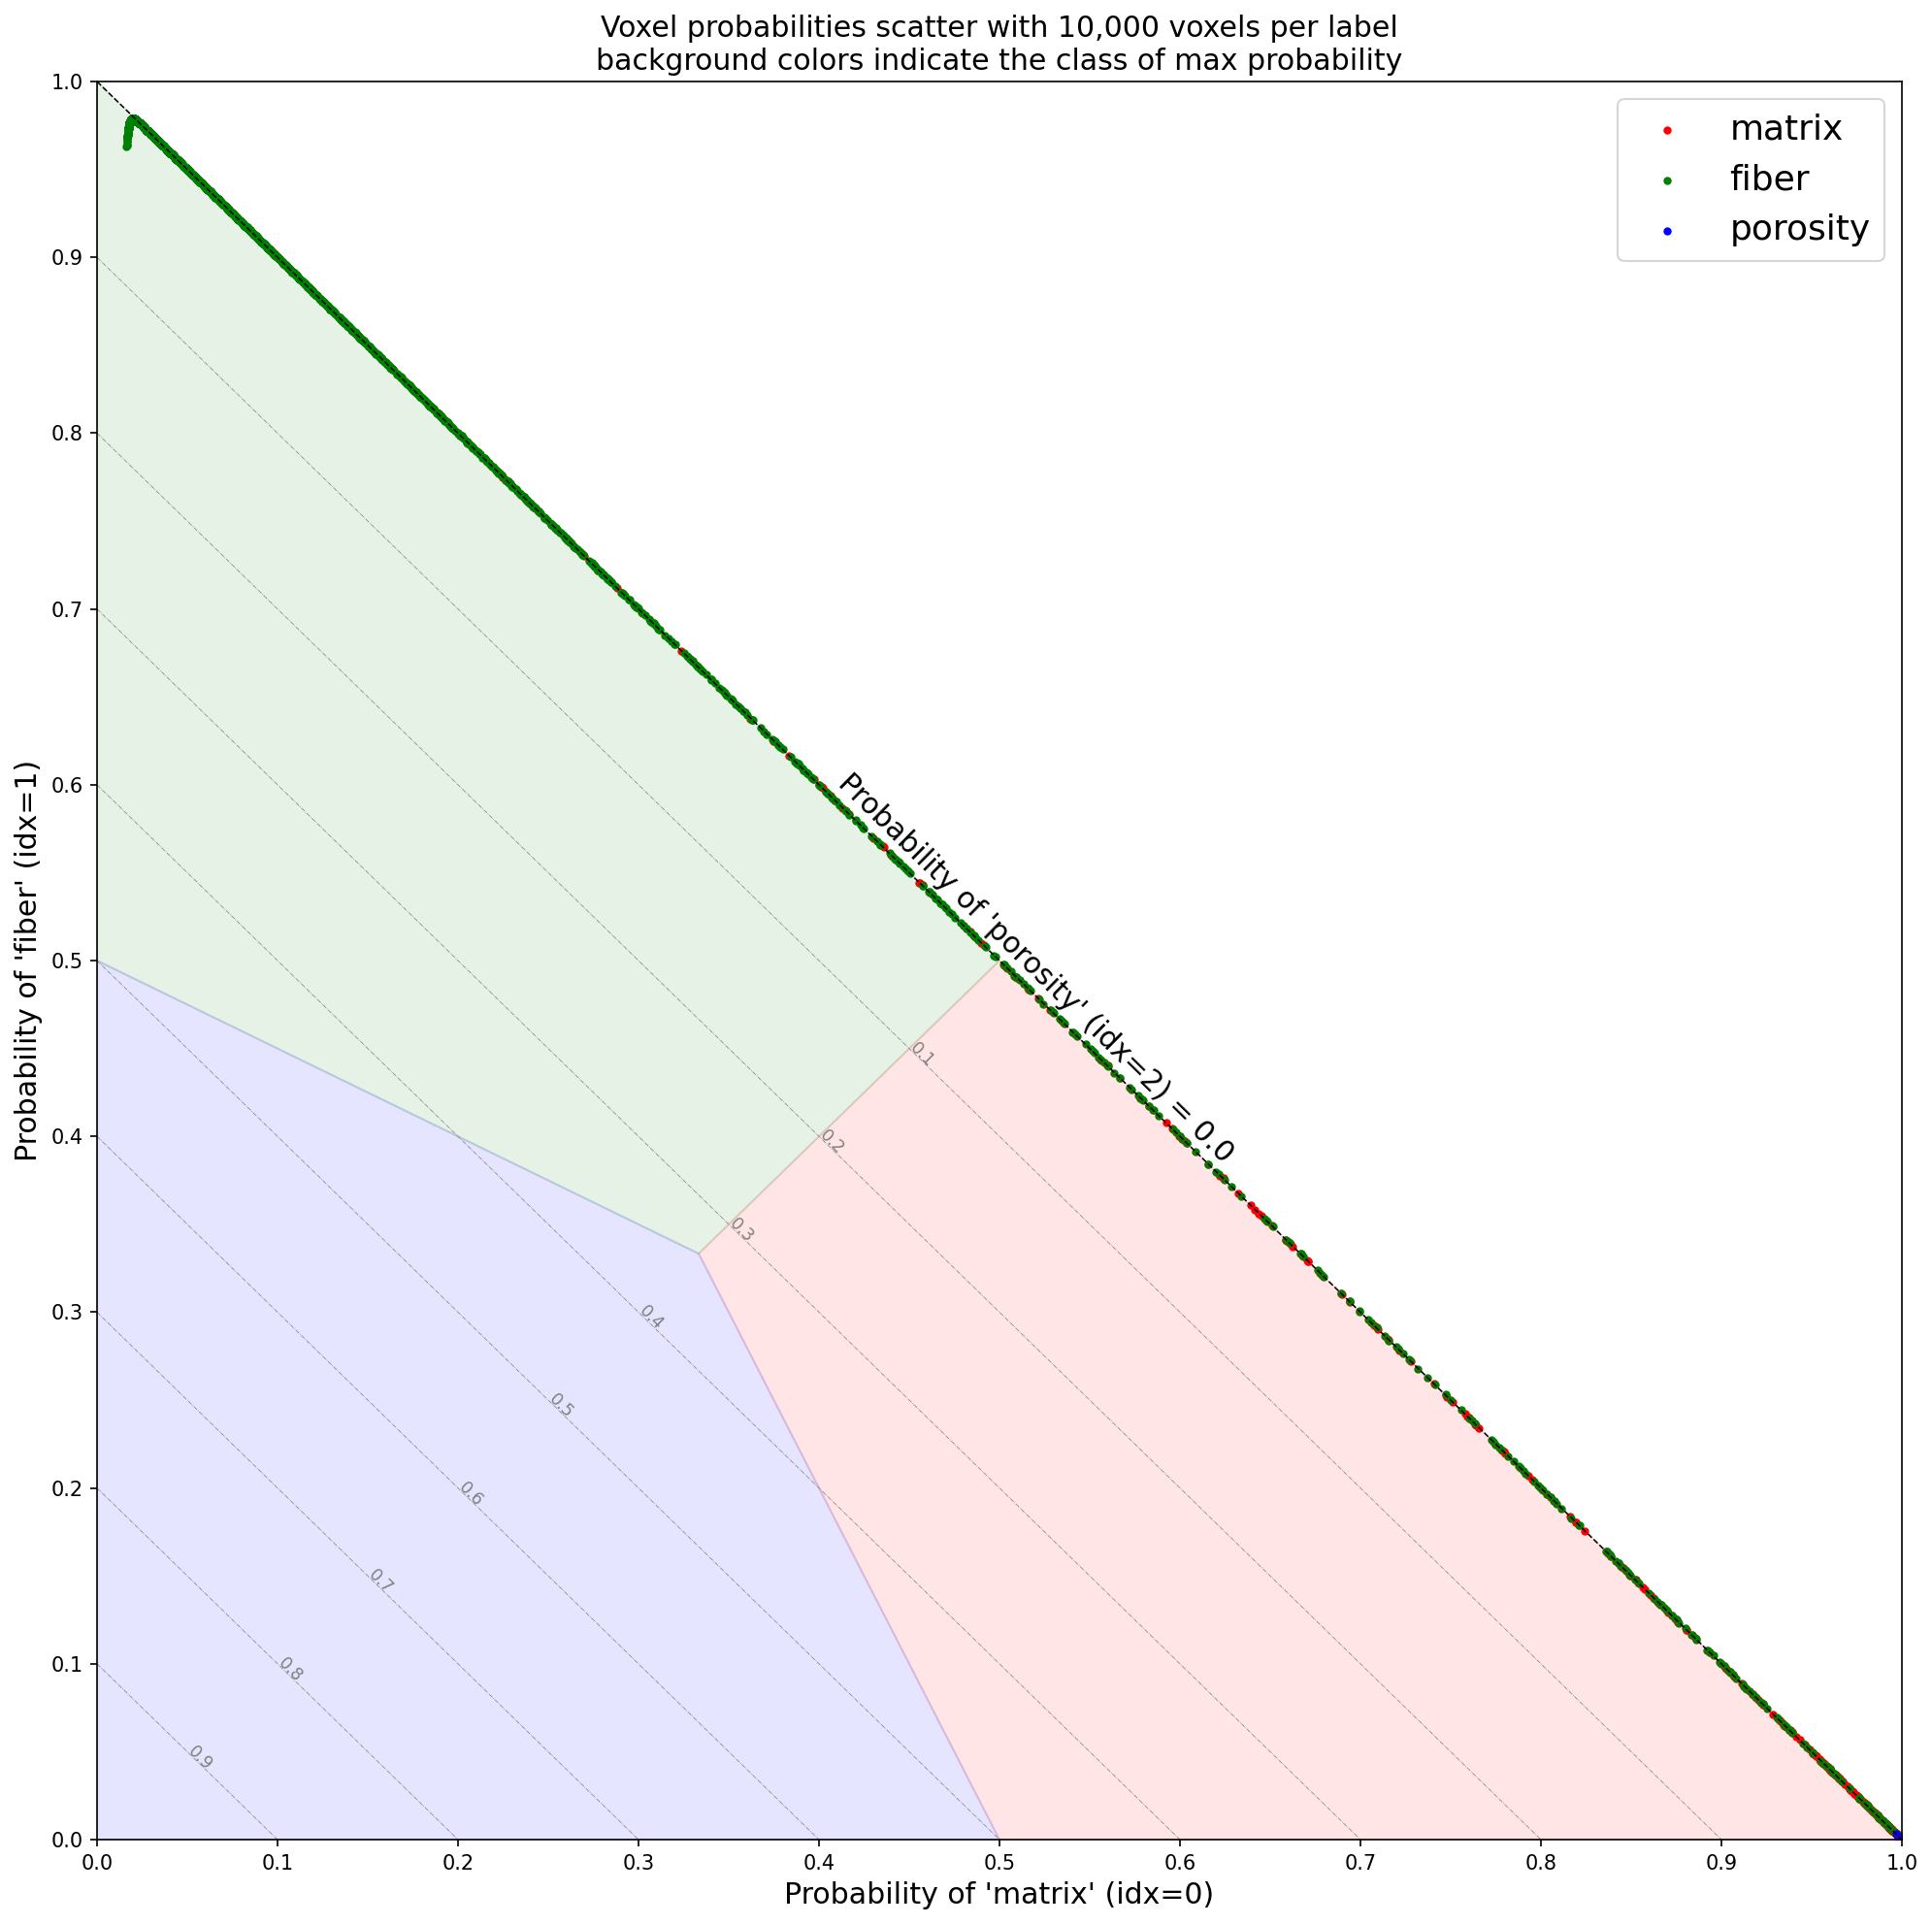

In [60]:
%%time

logger.info(
    f"Saving figure of probabilities scattered on a plane {(fig_name := f'probabilities-scatter.png')=}"
)

fig, ax = plt.subplots(
    n_rows := 1, 
    n_cols := 1, 
    figsize=(n_cols * (sz := 16), n_rows * sz), 
    dpi=(dpi := 150),
)

x_label, y_label, z_label = labels_idx

logger.debug(f"{(x_label, y_label, z_label)=}")

colors = ['r', 'g', 'b']
argmax_points = [
    xmax_points := np.array([[.5, 0], [1, 0], [.5, .5], [1./3, 1./3]]),
    ymax_points := np.vstack([xmax_points[:, 1], xmax_points[:, 0]]).T,
    zmax_points := np.array([[0, 0], [0, .5], [1./3, 1./3], [.5, 0]]),
]

for points, c in zip(argmax_points, colors):
    ax.add_patch(matplotlib.patches.Polygon(points, color=c, alpha=.1))

n_per_label = int(1e4)
logger.debug(f"{n_per_label=}")

ax.set_xlim(0, 1 + (margin := .00))
ax.set_ylim(0, 1 + margin)

ticks = np.linspace(0, 1, 11)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_title(
    f"Voxel probabilities scatter with {humanize.intcomma(n_per_label)} voxels per label\n"
    "background colors indicate the class of max probability",
    fontsize='x-large'
) 
ax.set_xlabel(f"Probability of '{labels_names[x_label]}' (idx={x_label})", fontsize='x-large')
ax.set_ylabel(f"Probability of '{labels_names[y_label]}' (idx={y_label})", fontsize='x-large')

for third_proba in ticks[1:-1]:
    ax.plot([0, third_proba], [third_proba, 0], c='gray', ls='-.', linewidth=.35)
    ax.text(third_proba / 2, third_proba / 2, f"{1. - third_proba:.1f}", c='gray', rotation=-45, rotation_mode='anchor', fontsize='small')
ax.plot([0, 1], [1, 0], c='k', ls='--', linewidth=.75)
ax.text((p := .4) + .01, 1 - p, f"Probability of '{labels_names[z_label]}' (idx={z_label}) = 0.0", c='k', rotation=-44.5, rotation_mode='anchor', fontsize='x-large')

for label_idx, c, label_name in zip(labels_idx, colors, labels_names):
    logger.debug(f"{label_idx=}")
    sample = probas_volume_reshaped[labels_volume.ravel() == label_idx, :]
    idx = random_state.choice(
        np.arange(0, len(sample)), size=n_per_label, replace=False
    )
    sample = sample[idx, :]
    logger.debug(f"{label_idx=}  {len(sample)=}")
    ax.scatter(
        sample[:, x_label], sample[:, y_label],
        c=c, marker='.', label=label_name
    )
    
ax.legend(loc='upper right', fontsize='xx-large')

In [61]:
del probas_volume_reshaped

# Pixel-wise metrics

## Classification report

In [62]:
classification_report_func = functools.partial(
    metrics.classification_report,
    # options
    labels=labels_idx,
    target_names=labels_names,
    sample_weight=None,
    output_dict=True,
    zero_division="warn",
)

In [63]:
%%time
logger.info("Computing classification report")
classification_report = classification_report_func(
    labels_volume.ravel(), predictions_volume.ravel(),
)

INFO::tomo2seg::{<timed exec>:<module>:001}::[2020-12-01::23:19:31.446]
Computing classification report



/home/joaopcbertoldo/projects/tomo2seg/condaenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 4.46 s, sys: 157 ms, total: 4.62 s
Wall time: 4.62 s


### extra: jaccard

In [64]:
jaccard_binary_func = functools.partial(
    metrics.jaccard_score, labels=labels_idx, average=None
)

jaccard_macro_func = functools.partial(
    metrics.jaccard_score, labels=labels_idx, average="macro",
)

jaccard_weighted_func = functools.partial(
    metrics.jaccard_score, labels=labels_idx, average="weighted",
)

In [65]:
logger.info("Computing jaccard score.")

logger.debug("Computing jaccard score per label.")
bin_jacc = jaccard_binary_func(labels_volume.ravel(), predictions_volume.ravel())

for label_idx, label_name in zip(labels_idx, labels_names):
    classification_report[label_name]["jaccard"] = float(bin_jacc[label_idx])
    
logger.debug("Computing jaccard score averages.")
classification_report["macro avg"]["jaccard"] = float(
    jaccard_macro_func(labels_volume.ravel(), predictions_volume.ravel())
)
classification_report["weighted avg"]["jaccard"] = float(
    jaccard_weighted_func(labels_volume.ravel(), predictions_volume.ravel())
)

INFO::tomo2seg::{<ipython-input-65-3645c0d77f4a>:<module>:001}::[2020-12-01::23:19:41.692]
Computing jaccard score.

DEBUG::tomo2seg::{<ipython-input-65-3645c0d77f4a>:<module>:003}::[2020-12-01::23:19:41.693]
Computing jaccard score per label.

DEBUG::tomo2seg::{<ipython-input-65-3645c0d77f4a>:<module>:009}::[2020-12-01::23:19:42.761]
Computing jaccard score averages.



### extra: Normalized Discounted Cumulative Gain (ndcg)

### Save

In [70]:
class HumanizedDumper(yaml.Dumper):
    pass
   

def percentage_float_representer(dumper, value):
    return dumper.represent_scalar(u'tag:yaml.org,2002:str', f"{value:.2%}")


def humanize_int_representer(dumper, value):
    return dumper.represent_scalar(u'tag:yaml.org,2002:str', f"{humanize.intword(value)} ({humanize.intcomma(value)})")


HumanizedDumper.add_representer(float, percentage_float_representer)
HumanizedDumper.add_representer(int, humanize_int_representer)

In [71]:
yaml_dump_classification_report = functools.partial(
    yaml.dump,
    default_flow_style=False, 
    indent=4, 
    sort_keys=False
)

In [74]:
logger.info(
    f"Saving exact and humanized classification report to (respectively):"
    f"\n{estimation_volume.voxelwise_classification_report_exact}"
    f"\n{estimation_volume.voxelwise_classification_report_human}"
)

with estimation_volume.voxelwise_classification_report_exact.open('w') as f:
    yaml_dump_classification_report(classification_report, f)

with estimation_volume.voxelwise_classification_report_human.open('w') as f:
    report_str = yaml_dump_classification_report(classification_report, Dumper=HumanizedDumper)
    f.write(report_str)

INFO::tomo2seg::{<ipython-input-74-da4fb1b68568>:<module>:001}::[2020-12-01::23:21:47.521]
Saving exact and humanized classification report to (respectively):
/home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056.voxelwise-classification-report.exact.yaml
/home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056.voxelwise-classification-report.human.yaml



In [75]:
print(report_str)

matrix:
    precision: 97.86%
    recall: 99.14%
    f1-score: 98.50%
    support: 3.3 million (3,345,708)
    jaccard: 97.04%
fiber:
    precision: 96.41%
    recall: 97.21%
    f1-score: 96.81%
    support: 798453 (798,453)
    jaccard: 93.81%
porosity:
    precision: 0.00%
    recall: 0.00%
    f1-score: 0.00%
    support: 50143 (50,143)
    jaccard: 0.00%
accuracy: 97.58%
macro avg:
    precision: 64.76%
    recall: 65.45%
    f1-score: 65.10%
    support: 4.2 million (4,194,304)
    jaccard: 63.62%
weighted avg:
    precision: 96.42%
    recall: 97.58%
    f1-score: 97.00%
    support: 4.2 million (4,194,304)
    jaccard: 95.26%



In [77]:
with estimation_volume.voxelwise_classification_report_exact.open() as f:
# with estimation_volume.pixelwise_classification_report_human.open() as f:
    classification_report = yaml.load(f, Loader=yaml.Loader)

## Confusion matrix

In [79]:
%%time

logger.info("Computing confusion matrix.")

# doing it in batches to fit my pc memory...
n_batches = 30
batch_indices = np.linspace(0, n_voxels, n_batches + 1).astype(int)

confusion_matrix = np.zeros((n_classes, n_classes))

for s, e in pbar(zip(batch_indices[:-1], batch_indices[1:]), max_value=n_batches):
    confusion_matrix += metrics.confusion_matrix(
        # data
        labels_volume.ravel()[s:e], predictions_volume.ravel()[s:e],
        # options
        labels=volume.metadata.labels,
        sample_weight=None,
    )

INFO::tomo2seg::{<timed exec>:<module>:001}::[2020-12-01::23:23:37.162]
Computing confusion matrix.



100% (30 of 30) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


CPU times: user 6.41 s, sys: 11.5 ms, total: 6.42 s
Wall time: 6.4 s


In [80]:
logger.info(f"Saving confusion matrix to {estimation_volume.confusion_matrix_path=}.")

np.save(
    estimation_volume.confusion_matrix_path,
    confusion_matrix
)

INFO::tomo2seg::{<ipython-input-80-b8ed2af3b858>:<module>:001}::[2020-12-01::23:23:43.611]
Saving confusion matrix to estimation_volume.confusion_matrix_path=PosixPath('/home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056.confusion-matrix.npy').



DEBUG::tomo2seg::{<ipython-input-82-26bb9053ed07>:<module>:001}::[2020-12-01::23:23:57.526]
Saving figure (fig_name := 'confusion-matrix.png')='confusion-matrix.png'



<ipython-input-82-26bb9053ed07>:26: RuntimeWarning: invalid value encountered in true_divide
  cm_predicted_label_normalized := confusion_matrix / confusion_matrix.sum(axis=0).reshape(1, -1),


Text(0.5, 0.98, 'Global confusion matrix')

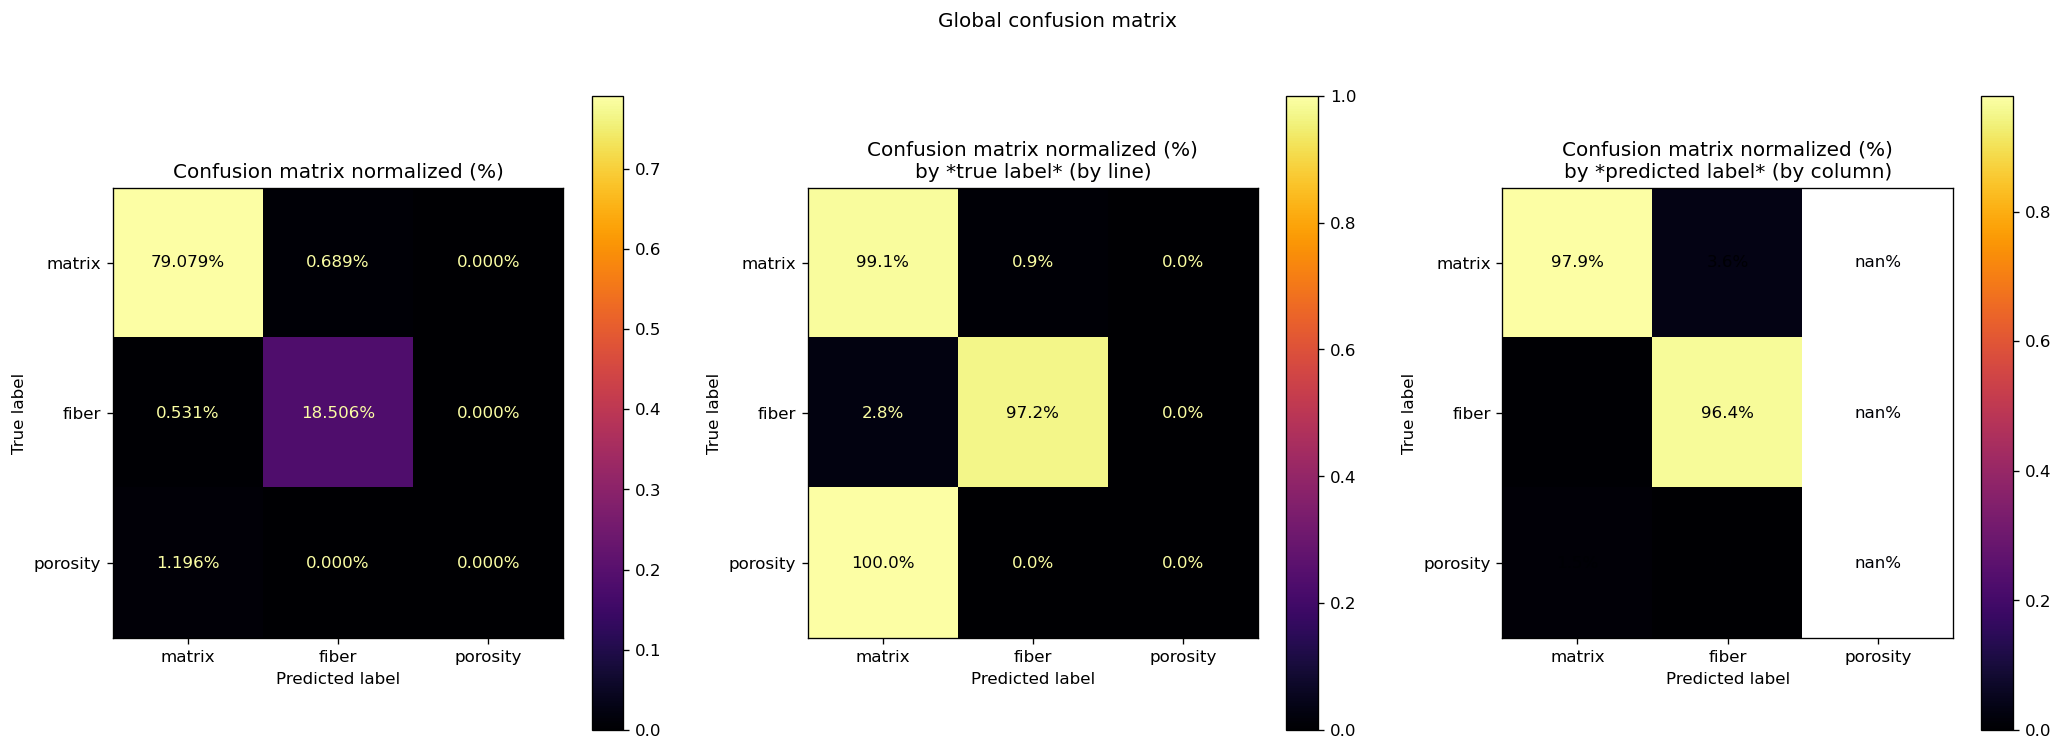

In [82]:
logger.debug(f"Saving figure {(fig_name := 'confusion-matrix.png')=}")

fig, axs = plt.subplots(
    n_rows := 1, 
    n_cols := 3, 
    figsize=(n_cols * (sz := 7), n_rows * sz), 
    dpi=(dpi := 120),
    gridspec_kw=dict(wspace=sz/30),
)

cm_display = metrics.ConfusionMatrixDisplay(
    cm_normalized := confusion_matrix / confusion_matrix.sum(), 
    display_labels=labels_names,
)
cm_display.plot(values_format='.3%', cmap=cm.inferno, ax=axs[0])
cm_display.ax_.set_title("Confusion matrix normalized (%)")

cm_display = metrics.ConfusionMatrixDisplay(
    cm_true_label_normalized := confusion_matrix / confusion_matrix.sum(axis=1).reshape(-1, 1), 
    display_labels=labels_names,
)
cm_display.plot(values_format='.1%', cmap=cm.inferno, ax=axs[1])
cm_display.ax_.set_title("Confusion matrix normalized (%)\nby *true label* (by line)")

cm_display = metrics.ConfusionMatrixDisplay(
    cm_predicted_label_normalized := confusion_matrix / confusion_matrix.sum(axis=0).reshape(1, -1), 
    display_labels=labels_names,
)
cm_display.plot(values_format='.1%', cmap=cm.inferno, ax=axs[2])
cm_display.ax_.set_title("Confusion matrix normalized (%)\nby *predicted label* (by column)")

fig.suptitle("Global confusion matrix")

# fig.savefig(
#     fname=estimation_volume.dir / fig_name,
#     dpi=dpi,
#     **figs_common_kwargs,
#     metadata={
#         "Title": f"vol={volume.fullname}::analysis::{fig_name}",
#         **figs_common_kwargs
#     }
# )

## Binary confusion matrices

In [83]:
logger.info("Computing binary confusion matrices (per label).")

binary_confusion_matrices = []

for label_idx in range(n_classes):
    tp = confusion_matrix[label_idx, label_idx]
    fn = confusion_matrix[label_idx, :].sum() - tp
    fp = confusion_matrix[:, label_idx].sum() - tp
    tn = confusion_matrix.sum() - fp - fn - tp
    binary_confusion_matrices.append([
        [tn, fp],
        [fn, tp],
    ])
    
binary_confusion_matrices = np.array(binary_confusion_matrices)

logger.debug(f"{binary_confusion_matrices.shape=}")

INFO::tomo2seg::{<ipython-input-83-c2878c54b2e0>:<module>:001}::[2020-12-01::23:24:00.563]
Computing binary confusion matrices (per label).

DEBUG::tomo2seg::{<ipython-input-83-c2878c54b2e0>:<module>:017}::[2020-12-01::23:24:00.564]
binary_confusion_matrices.shape=(3, 2, 2)



In [84]:
logger.info(f"Saving binary confusion matrices to {estimation_volume.binary_confusion_matrices_path}.")
np.save(
    estimation_volume.binary_confusion_matrices_path,
    binary_confusion_matrices
)

INFO::tomo2seg::{<ipython-input-84-4e7148cd3762>:<module>:001}::[2020-12-01::23:24:02.080]
Saving binary confusion matrices to /home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056.binary-confusion-matrices.npy.



INFO::tomo2seg::{<ipython-input-85-039ebc9e509c>:<module>:001}::[2020-12-01::23:24:02.716]
Saving figure of binary confusion matrices at (fig_name := f'binary-confusion-matrices.png')='binary-confusion-matrices.png'

DEBUG::tomo2seg::{<ipython-input-85-039ebc9e509c>:<module>:015}::[2020-12-01::23:24:02.900]
Drawing CM of class label_idx=0 (1st line)

DEBUG::tomo2seg::{<ipython-input-85-039ebc9e509c>:<module>:015}::[2020-12-01::23:24:02.954]
Drawing CM of class label_idx=1 (1st line)

DEBUG::tomo2seg::{<ipython-input-85-039ebc9e509c>:<module>:015}::[2020-12-01::23:24:03.003]
Drawing CM of class label_idx=2 (1st line)

DEBUG::tomo2seg::{<ipython-input-85-039ebc9e509c>:<module>:029}::[2020-12-01::23:24:03.056]
Drawing CM of class label_idx=0 (2nd line)

DEBUG::tomo2seg::{<ipython-input-85-039ebc9e509c>:<module>:029}::[2020-12-01::23:24:03.111]
Drawing CM of class label_idx=1 (2nd line)

DEBUG::tomo2seg::{<ipython-input-85-039ebc9e509c>:<module>:029}::[2020-12-01::23:24:03.149]
Drawing CM 

<ipython-input-85-039ebc9e509c>:33: RuntimeWarning: invalid value encountered in true_divide
  confmat / confmat.sum(axis=0).reshape(1, -1),


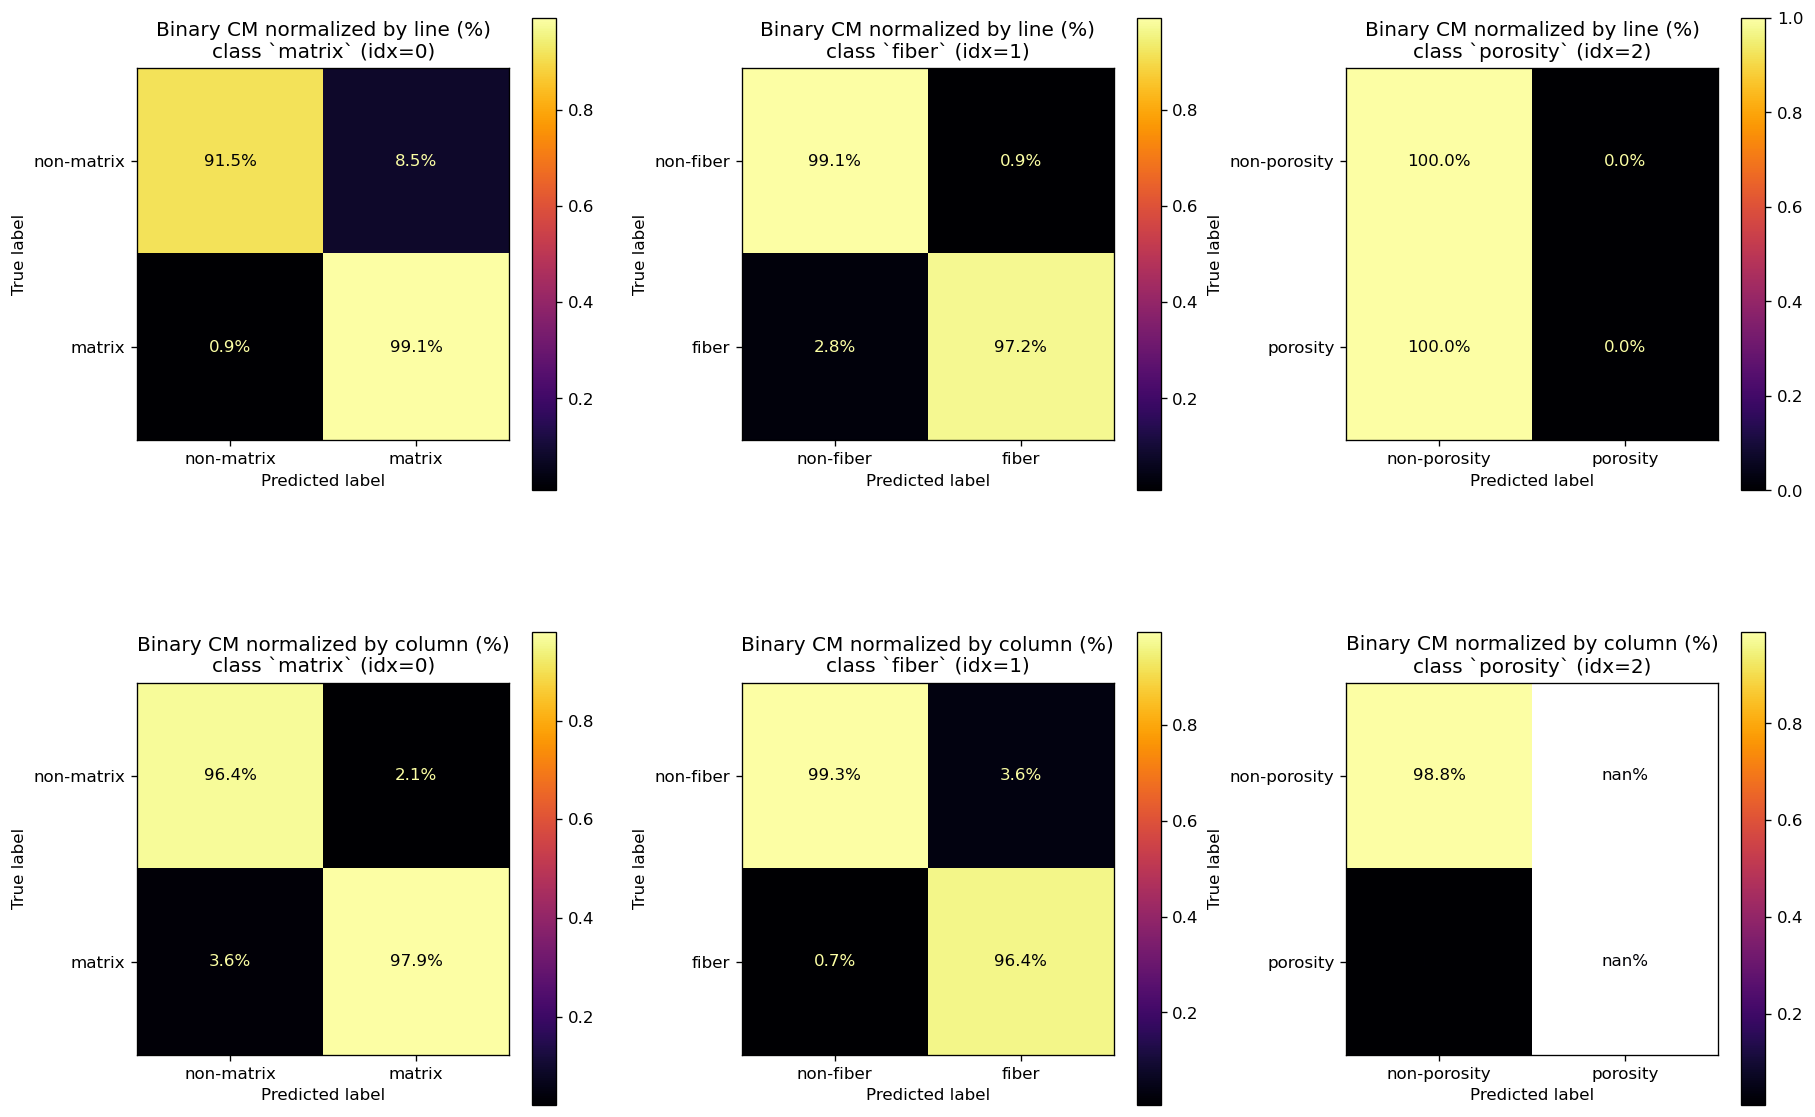

In [85]:
logger.info(
    f"Saving figure of binary confusion matrices at "
    f"{(fig_name := f'binary-confusion-matrices.png')=}"
)

fig, axs = plt.subplots(
    n_rows := 2, 
    n_cols := n_classes, 
    figsize=(n_cols * (sz := 6), n_rows * sz), 
    dpi=(dpi := 120),
    gridspec_kw=dict(wspace=sz/20, hspace=sz/20),
)

for label_idx, ax in zip(labels_idx, axs[0].ravel()):
    logger.debug(f"Drawing CM of class {label_idx=} (1st line)")
    confmat = binary_confusion_matrices[label_idx]
    
    cm_display = metrics.ConfusionMatrixDisplay(
        confmat / confmat.sum(axis=1).reshape(-1, 1), 
        display_labels=[f"non-{(label_name := labels_names[label_idx])}", label_name],
    )
    cm_display.plot(values_format='.1%', cmap=cm.inferno, ax=ax)
    cm_display.ax_.set_title(
        f"Binary CM normalized by line (%)\n"
        f"class `{label_name}` (idx={label_idx})"
    )

for label_idx, ax in zip(labels_idx, axs[1].ravel()):
    logger.debug(f"Drawing CM of class {label_idx=} (2nd line)")
    confmat = binary_confusion_matrices[label_idx]
    
    cm_display = metrics.ConfusionMatrixDisplay(
        confmat / confmat.sum(axis=0).reshape(1, -1), 
        display_labels=[f"non-{(label_name := labels_names[label_idx])}", label_name],
    )
    cm_display.plot(values_format='.1%', cmap=cm.inferno, ax=ax)
    cm_display.ax_.set_title(
        f"Binary CM normalized by column (%)\n"
        f"class `{label_name}` (idx={label_idx})"
    )

## ROC curves

In [86]:
logger.info("Computing ROC curves")

roc_curves = []

for label_idx in labels_idx:
    logger.debug(f"Computing roc curve of class idx={label_idx}")
    
    fpr, tpr, th = metrics.roc_curve(
        labels_volume.ravel(), probas_volume.reshape(-1, n_classes)[:, label_idx], 
        pos_label=label_idx,
        drop_intermediate=True
    )
    roc_curves.append((
        label_roc_curve := np.array([fpr, tpr, th])
    ))
    
    logger.debug(
        f"Saving roc curve of class idx={label_idx} "
        f"at {(roc_path := estimation_volume.get_class_roc_curve_path(label_idx))=}"
    )
    np.save(roc_path,label_roc_curve)

INFO::tomo2seg::{<ipython-input-86-0040b9433c04>:<module>:001}::[2020-12-01::23:24:08.658]
Computing ROC curves

DEBUG::tomo2seg::{<ipython-input-86-0040b9433c04>:<module>:006}::[2020-12-01::23:24:08.660]
Computing roc curve of class idx=0

DEBUG::tomo2seg::{<ipython-input-86-0040b9433c04>:<module>:017}::[2020-12-01::23:24:09.394]
Saving roc curve of class idx=0 at (roc_path := estimation_volume.get_class_roc_curve_path(label_idx))=PosixPath('/home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056.roc-curve.class-idx=0.raw')

DEBUG::tomo2seg::{<ipython-input-86-0040b9433c04>:<module>:006}::[2020-12-01::23:24:09.395]
Computing roc curve of class idx=1

DEBUG::tomo2seg::{<ipython-input-86-0040b9433c04>:<module>:017}::[2020-12-01::23:24:10.082]
Saving roc curve of class idx=1 at (roc_path := estima

INFO::tomo2seg::{<ipython-input-87-4ab6455845cf>:<module>:001}::[2020-12-01::23:24:57.335]
Saving figure of ROC curves at roc-curves.png



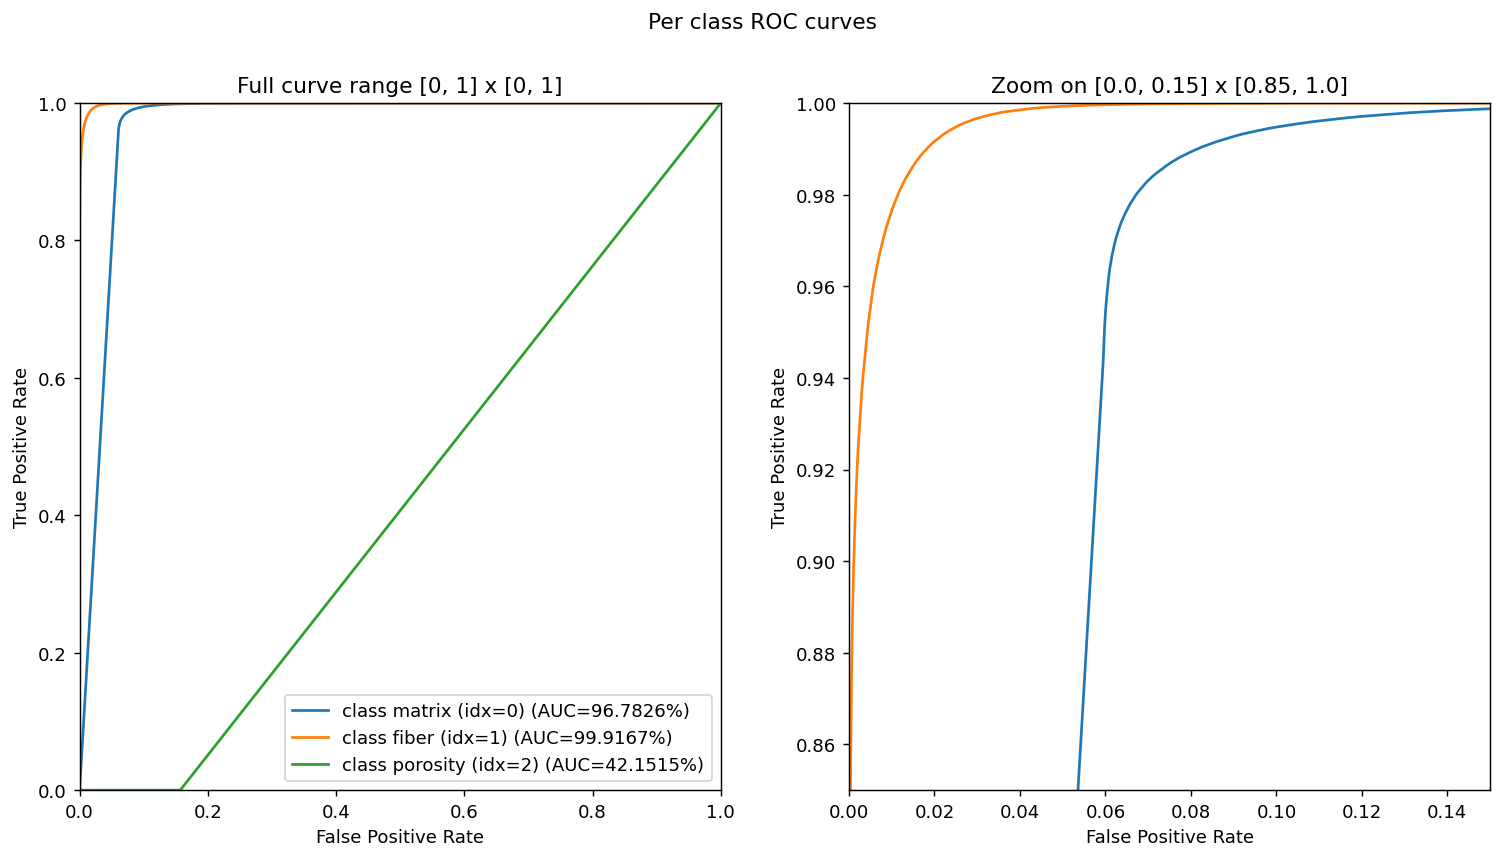

In [87]:
logger.info(f"Saving figure of ROC curves at {(fig_name := f'roc-curves.png')}")

fig, axs = plt.subplots(
    n_rows := 1, 
    n_cols := 2, 
    figsize=(n_cols * (sz := 7), n_rows * sz), 
    dpi=(dpi := 130),
)

zoom = np.array(((0, .15), (.85, 1)))

fig.suptitle("Per class ROC curves")

ax_full, ax_zoom = axs[0], axs[1]
ax_full.set_title("Full curve range [0, 1] x [0, 1]")
ax_full.set_xlim(0, 1)
ax_full.set_ylim(0, 1)

ax_zoom.set_title(f"Zoom on [{zoom[0, 0]}, {zoom[0, 1]}] x [{zoom[1, 0]}, {zoom[1, 1]}]")
ax_zoom.set_xlim(*zoom[0])
ax_zoom.set_ylim(*zoom[1])

for label_idx, (fpr, tpr, _) in zip(labels_idx, roc_curves):
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{label_idx}")
    for ax in axs:
        roc_display.plot(ax=ax)  

max_label_name_length = max(*map(len, labels_names))

for label_idx, (fpr, tpr, _) in zip(labels_idx, roc_curves):
    ax_full.get_legend().texts[label_idx].set_text(
        f"class {(label_name := labels_names[label_idx])} (idx={label_idx})"
        f" (AUC={(roc_auc := metrics.auc(fpr, tpr)):.4%})"
    )
ax_zoom.legend_ = None

# Confusion volume

In [88]:
logger.info("Computing confusion volumes")

for label_idx in labels_idx:

    tp_volume = (labels_volume == label_idx) & (predictions_volume == label_idx)
    fn_volume = (labels_volume == label_idx) & (predictions_volume != label_idx)
    fp_volume = (labels_volume != label_idx) & (predictions_volume == label_idx)

    conf_vol = (
        np.zeros_like(labels_volume, dtype=(vol_dtype := np.uint8))
        + 50 * fn_volume.astype(vol_dtype)
        + 100 * fp_volume.astype(vol_dtype)
        + 255 * tp_volume.astype(vol_dtype)
    )
    
    logger.debug(
        f"Saving confusion volume for class {label_idx=} "
        f"at {(str_path := str(estimation_volume.get_confusion_volume_path(label_idx)))=}"
    )
    file_utils.HST_write(conf_vol, str_path)    

INFO::tomo2seg::{<ipython-input-88-d1b9d481c42a>:<module>:001}::[2020-12-01::23:25:01.638]
Computing confusion volumes

DEBUG::tomo2seg::{<ipython-input-88-d1b9d481c42a>:<module>:016}::[2020-12-01::23:25:01.655]
Saving confusion volume for class label_idx=0 at (str_path := str(estimation_volume.get_confusion_volume_path(label_idx)))='/home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056.confusion-volume.class-idx=0.raw'

opening /home/joaopcbertoldo/projects/tomo2seg/data/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056/vol=PA66GF30.v1-reduced.set=test.model=unet-2d-small.vanilla00.fold000.1605-982-196.runid=1606-072-056.confusion-volume.class-idx=0.raw for writing in mode w
volume size is 256x256x64
data type is uint8
writing .info file
do

## 2D error blobs

## 3D error blobs

# Physical metrics

# Notable slices

In [ ]:
estimation_volume["lalala"] 